In [20]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import anndata as ad
import episcanpy.api as epi
import scanpy as sc
from scipy.sparse import csc_matrix

import os

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
import seaborn as sns


def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))
    
def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        #print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        #print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    #print('Cannot find the number of clusters')
    #print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))
    



# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
%%R -o features -o cells -o mtx
df_count = readRDS('./input/erythropoiesis_clean.rds')
mtx=as.matrix(df_count)
features = df_count@Dimnames[[1]]
cells = df_count@Dimnames[[2]]

In [6]:
# format the data
mtx=csc_matrix(mtx).transpose()
cells = cells.tolist()
features = features.tolist()

AnnData object with n_obs × n_vars = 1200 × 103670 
    obs: 'cell_type', 'n_features'
    var: 'n_cells'


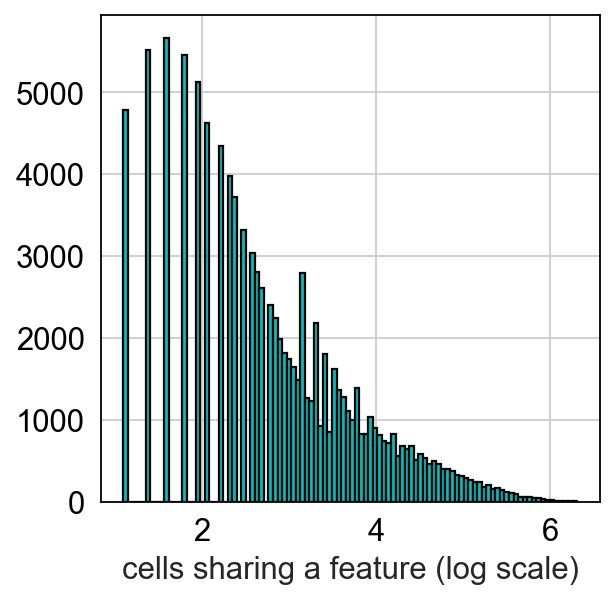

... storing 'cell_type' as categorical


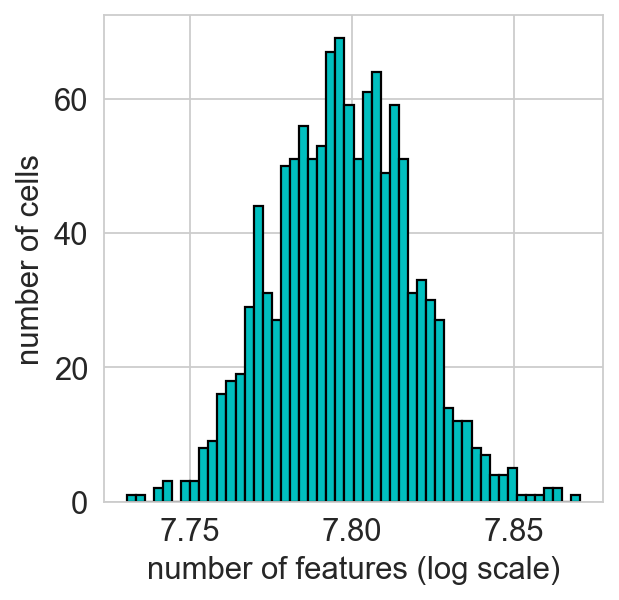

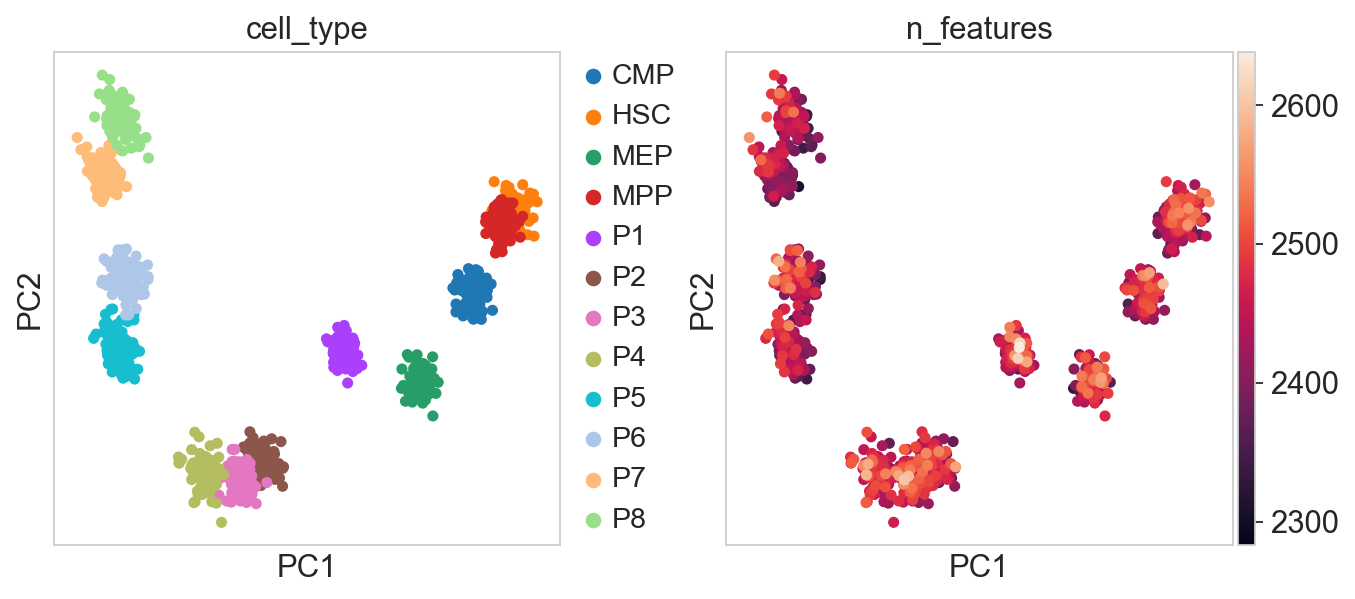

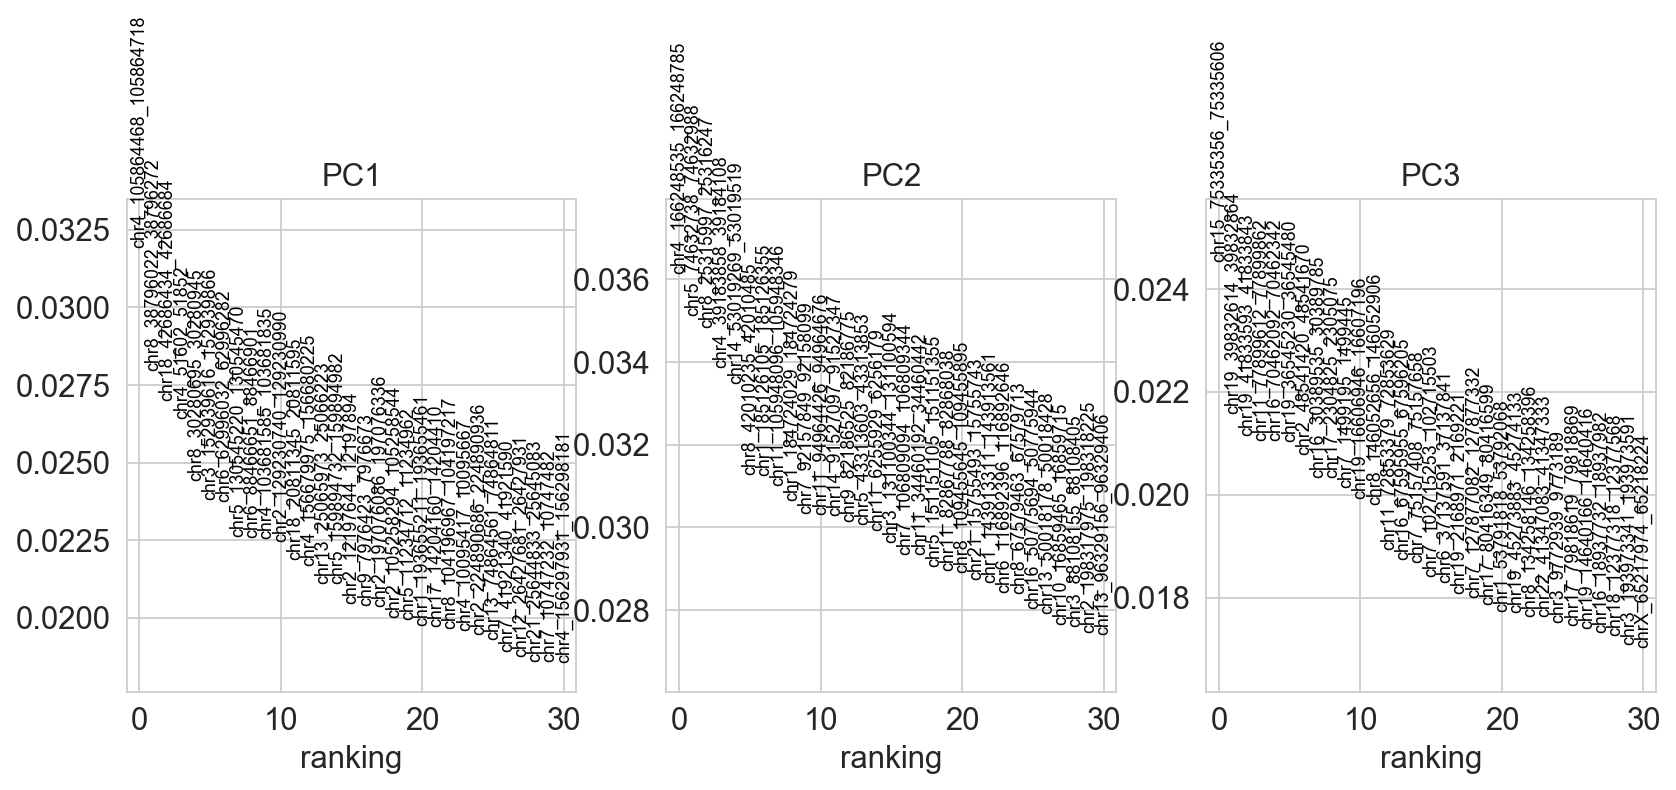

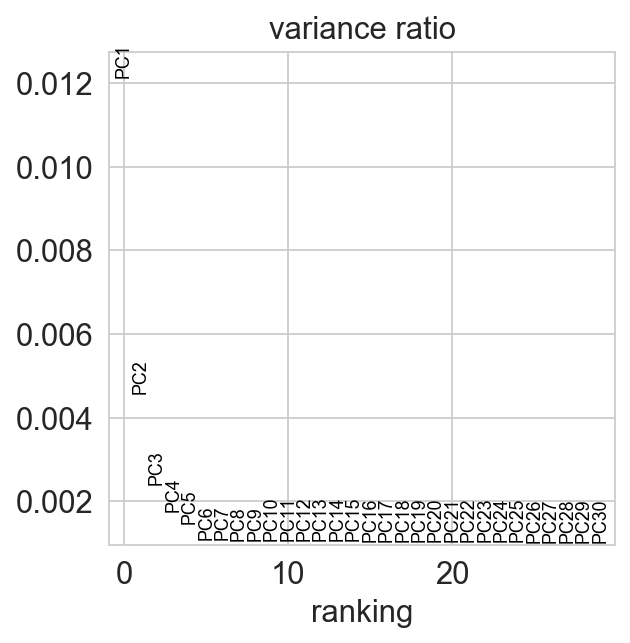

In [13]:
adata = ad.AnnData(mtx,
                   obs=pd.DataFrame(index=cells),
                   var=pd.DataFrame(index=features))

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

# load metadata
metadata = pd.read_csv('./input/metadata.tsv',sep='\t',index_col=0)
num_clusters = len(np.unique(metadata['label']))
adata.obs['cell_type'] = metadata['label']

epi.pp.binarize(adata)
adata

#epi.pp.commonness_features(adata, binary=True)
#epi.pp.coverage_cells(adata, binary=True)
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=3)

print(adata)
epi.pp.commonness_features(adata, binary=True, log=True)
epi.pp.coverage_cells(adata, binary=True, log=True)

sc.pp.pca(adata, n_comps=30)
sc.pl.pca_overview(adata, color=['cell_type', 'n_features'])


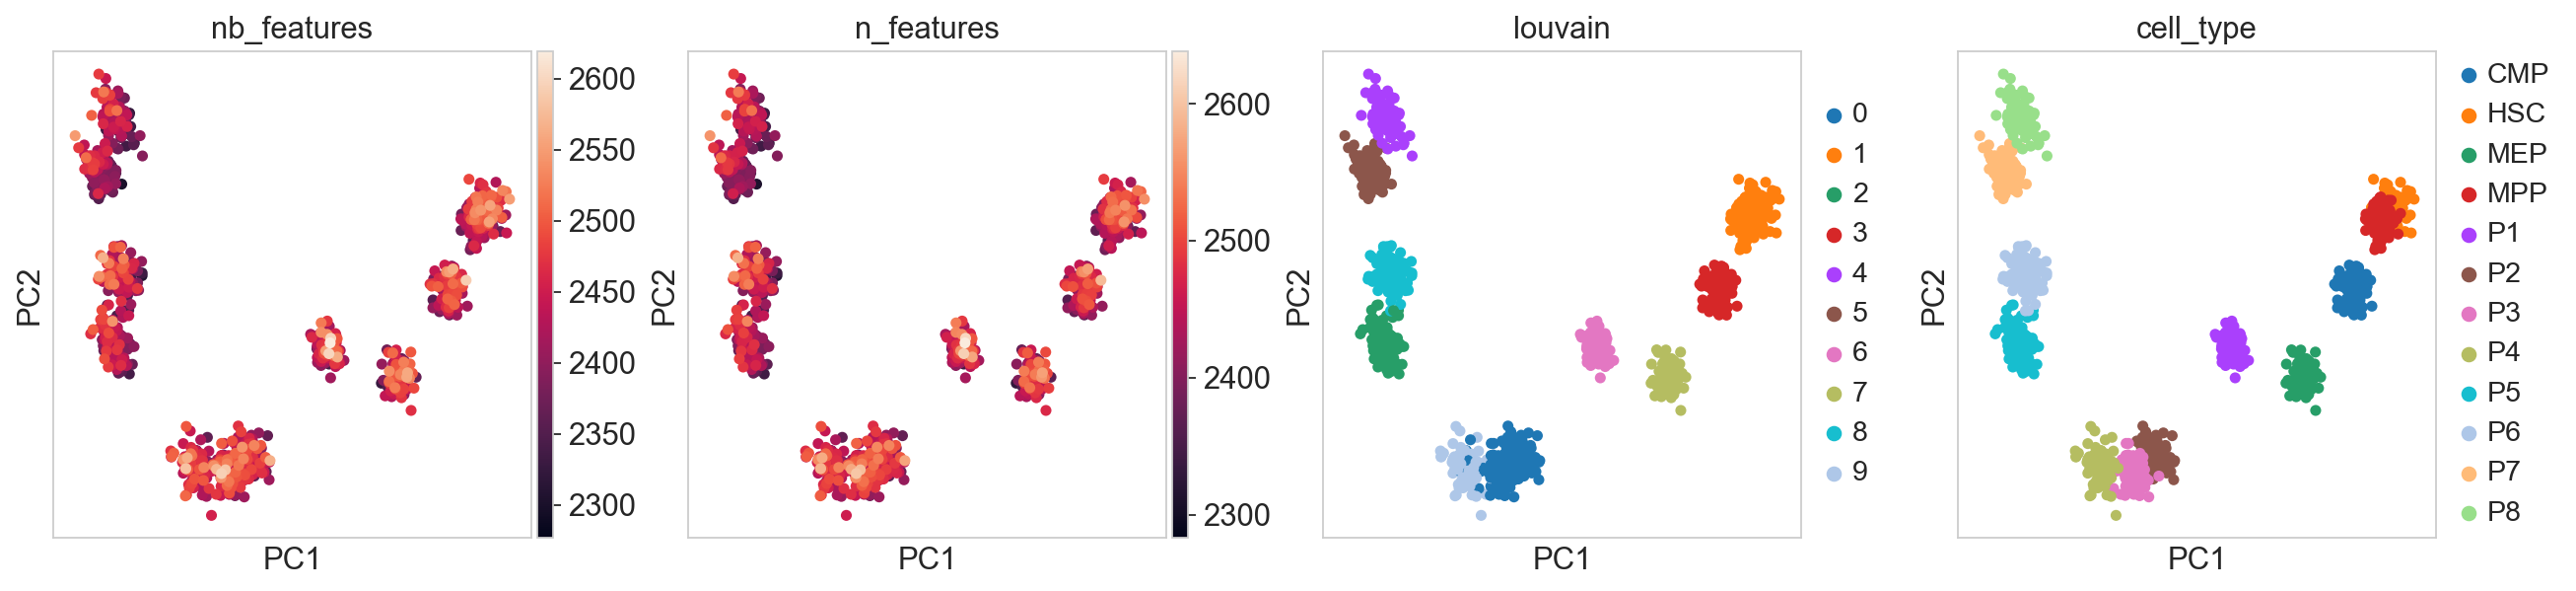

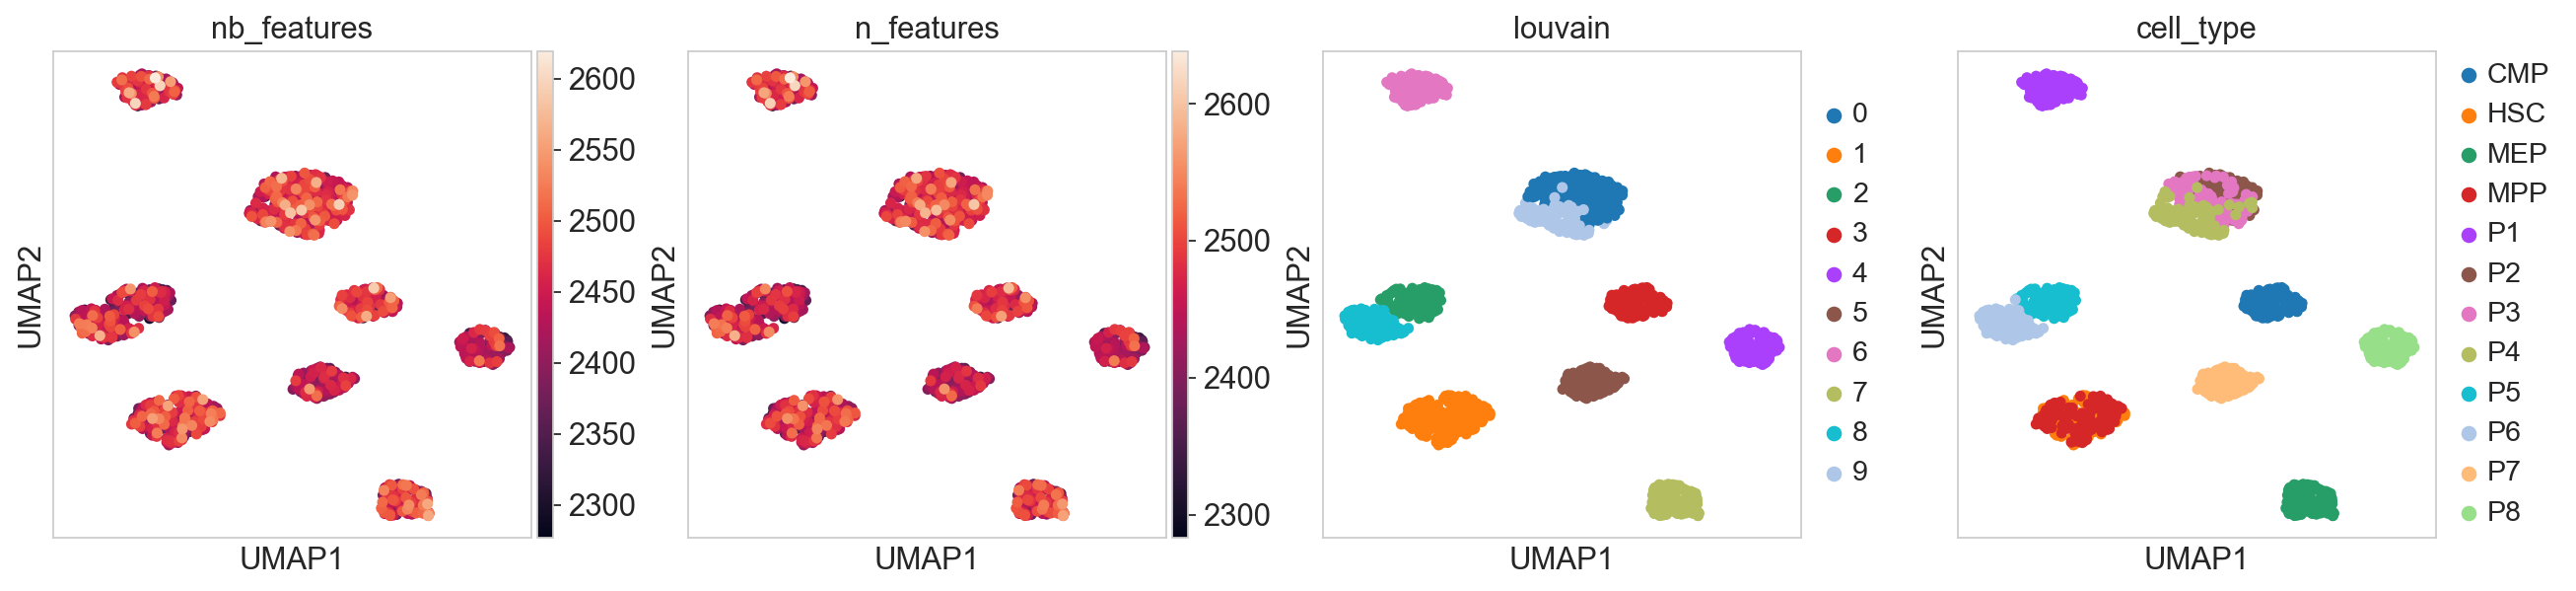

In [14]:
adatareduced = adata.copy()

epi.pp.pca(adatareduced, n_comps=7)
epi.pp.neighbors(adatareduced, n_neighbors=15, method='umap')
epi.tl.umap(adatareduced)
epi.tl.louvain(adatareduced)

sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])
sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

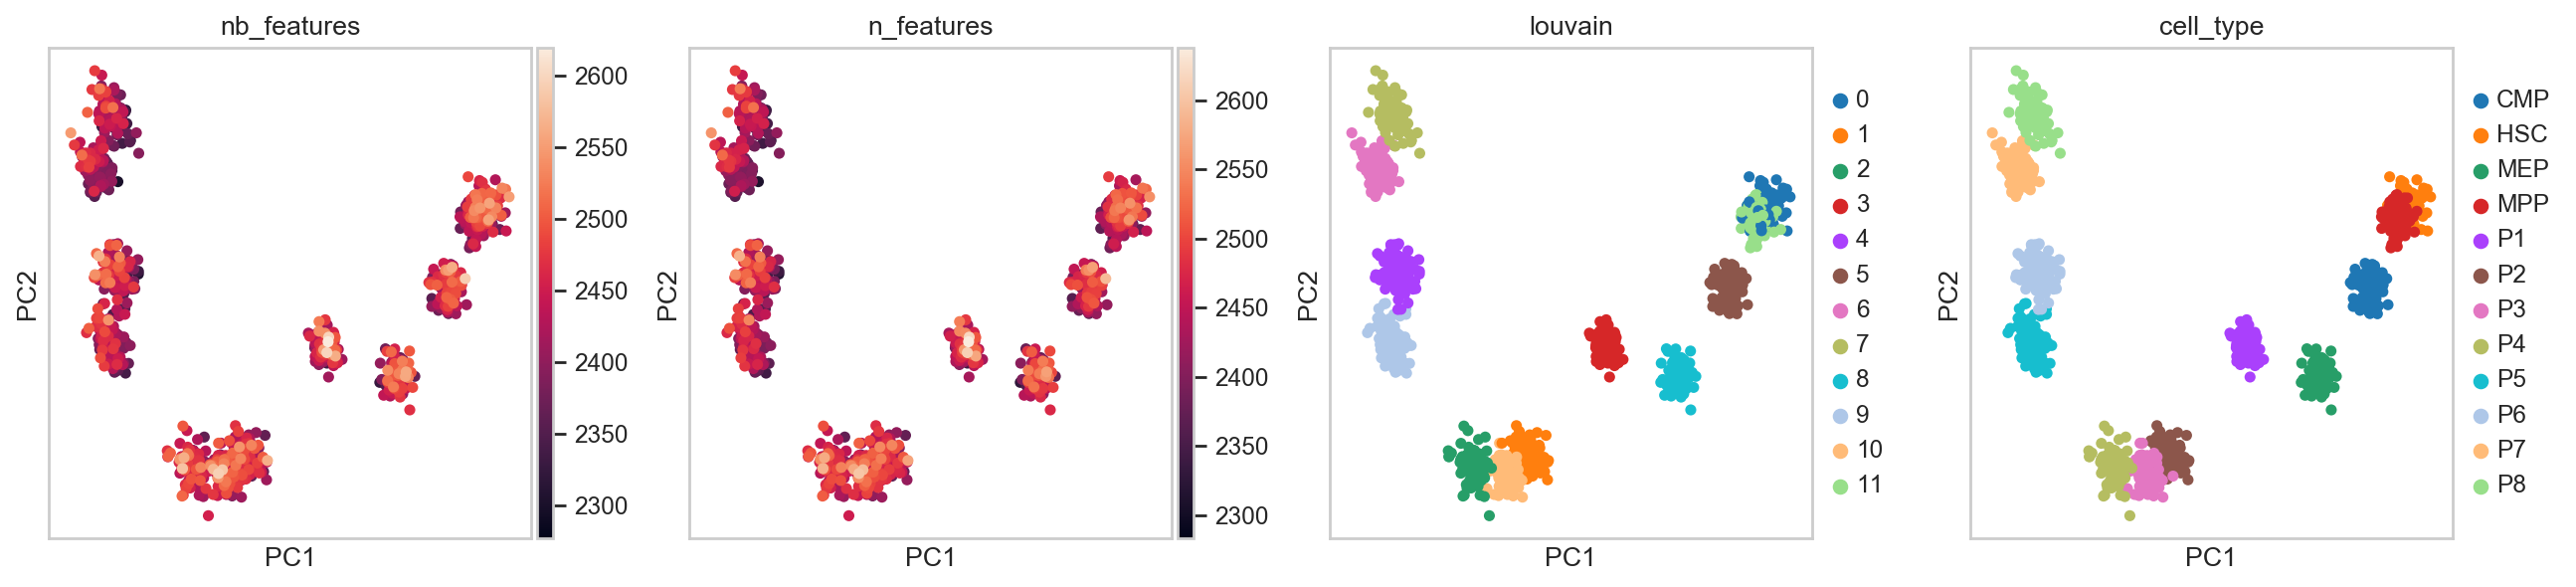

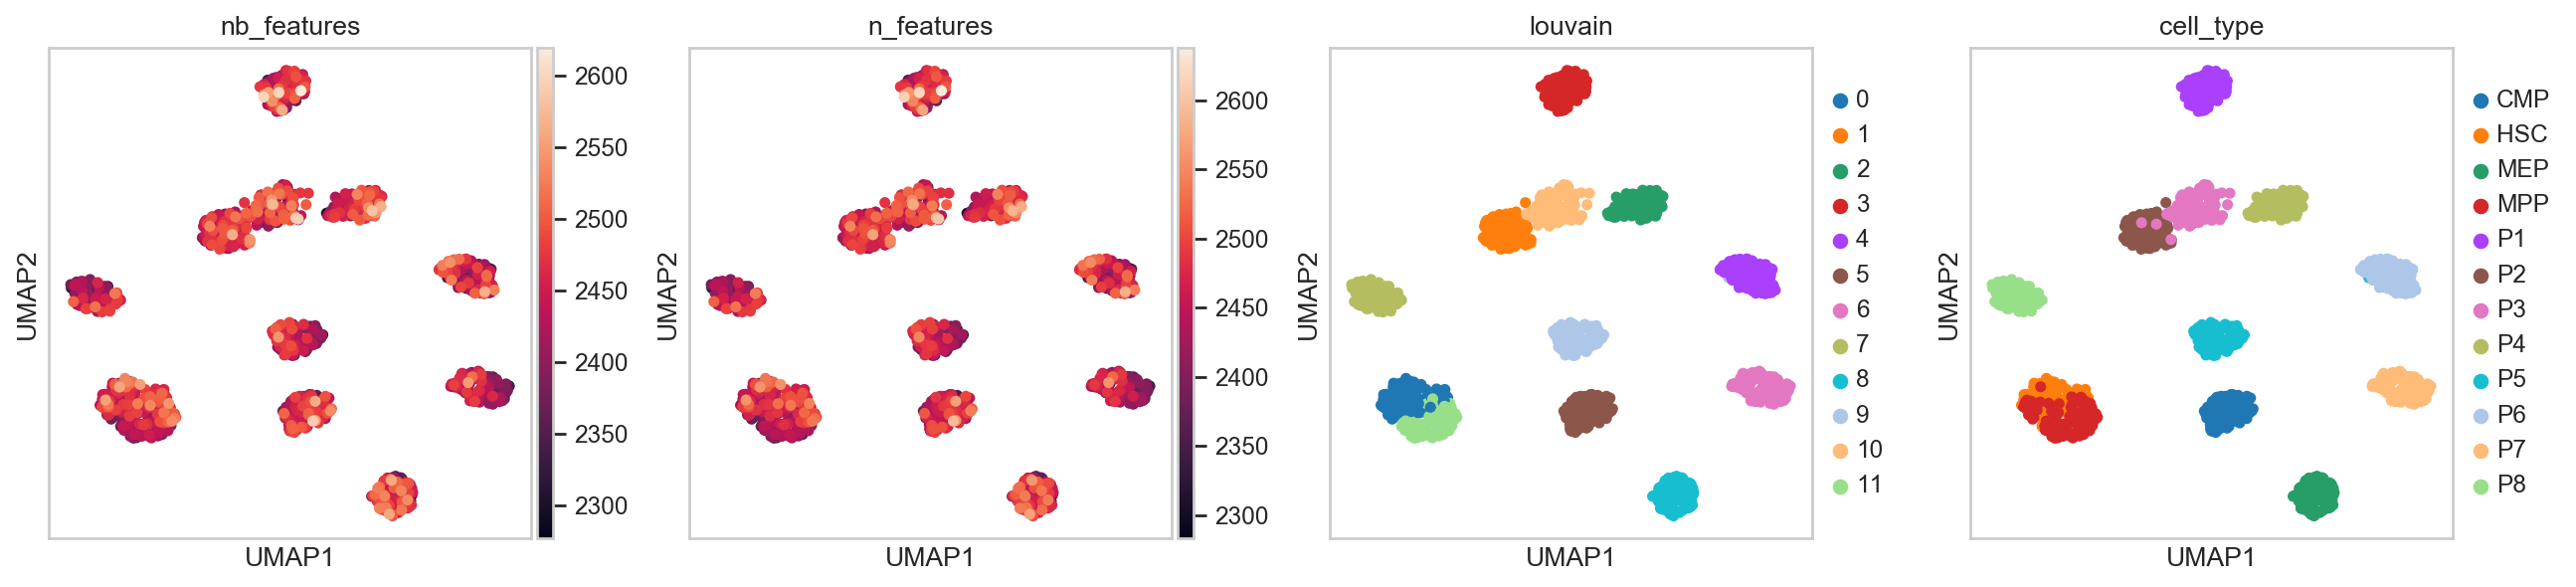

0.9295849302917766 0.8725641265692509 0.9073855264539338


In [27]:
adatareduced = adata.copy()
# convert the cell label to standard label
adatareduced.obs['label'] = adatareduced.obs['cell_type']


epi.pp.pca(adatareduced, n_comps=4)
sc.pp.neighbors(adatareduced, n_neighbors=15)
epi.tl.umap(adatareduced)
#epi.tl.louvain(adatareduced)
getNClusters(adatareduced,n_cluster=num_clusters)
#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['kmeans'] = pd.Series(kmeans.labels_,index=adatareduced.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['hc'] = pd.Series(hc.labels_,index=adatareduced.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
ari_kmeans = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
ari_hc = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['hc'])

sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])
sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

print(ari_louvain, ari_kmeans, ari_hc)

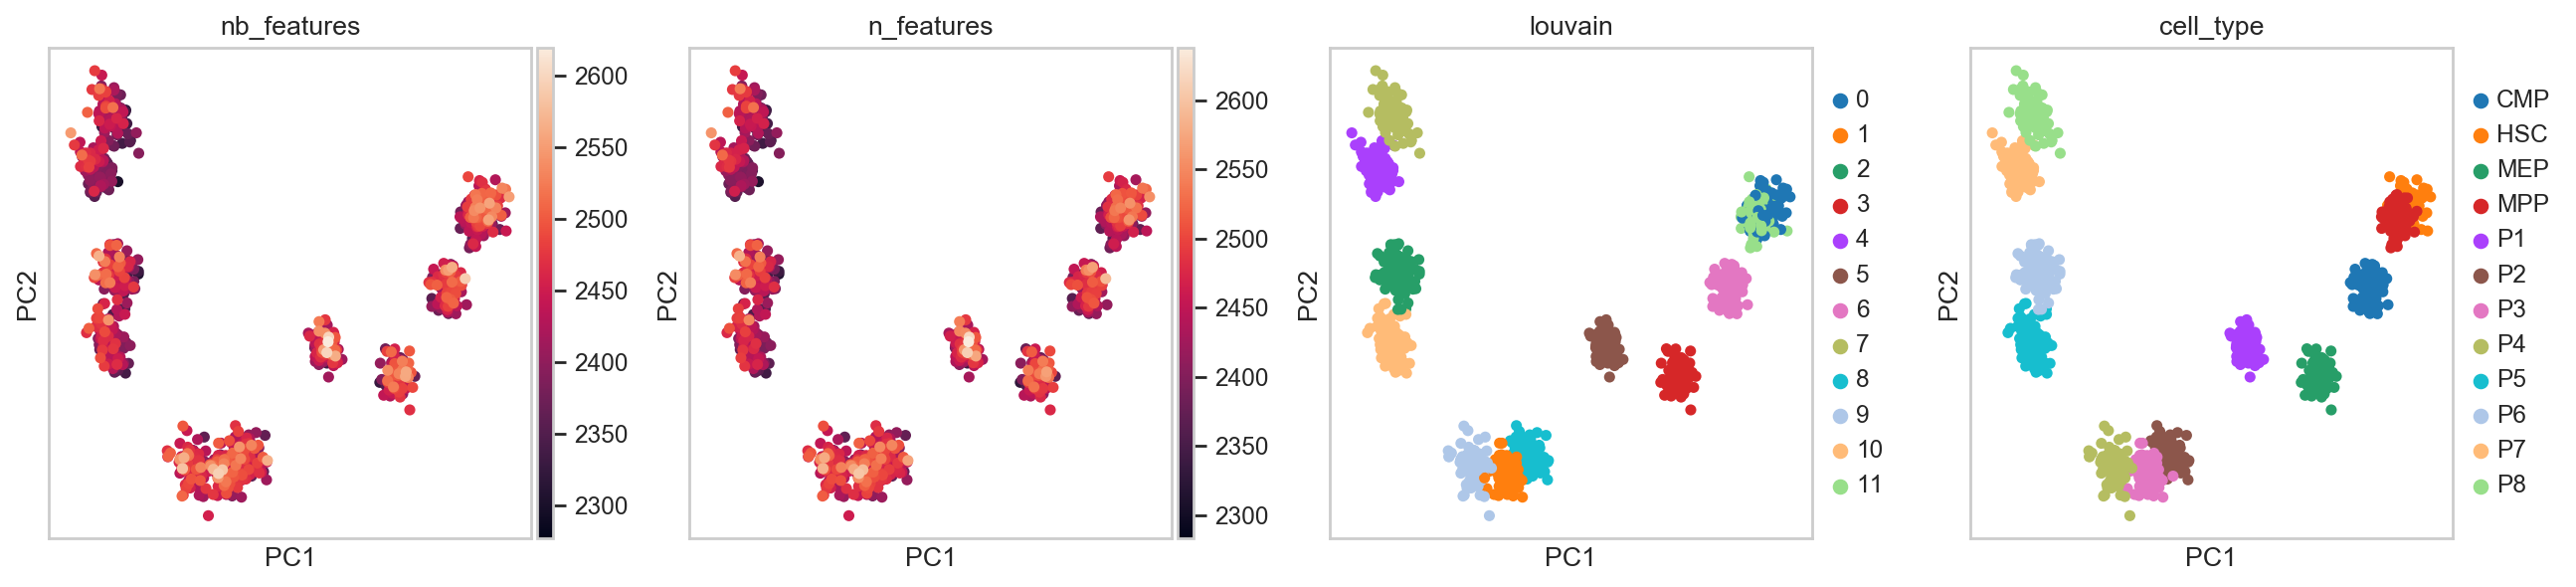

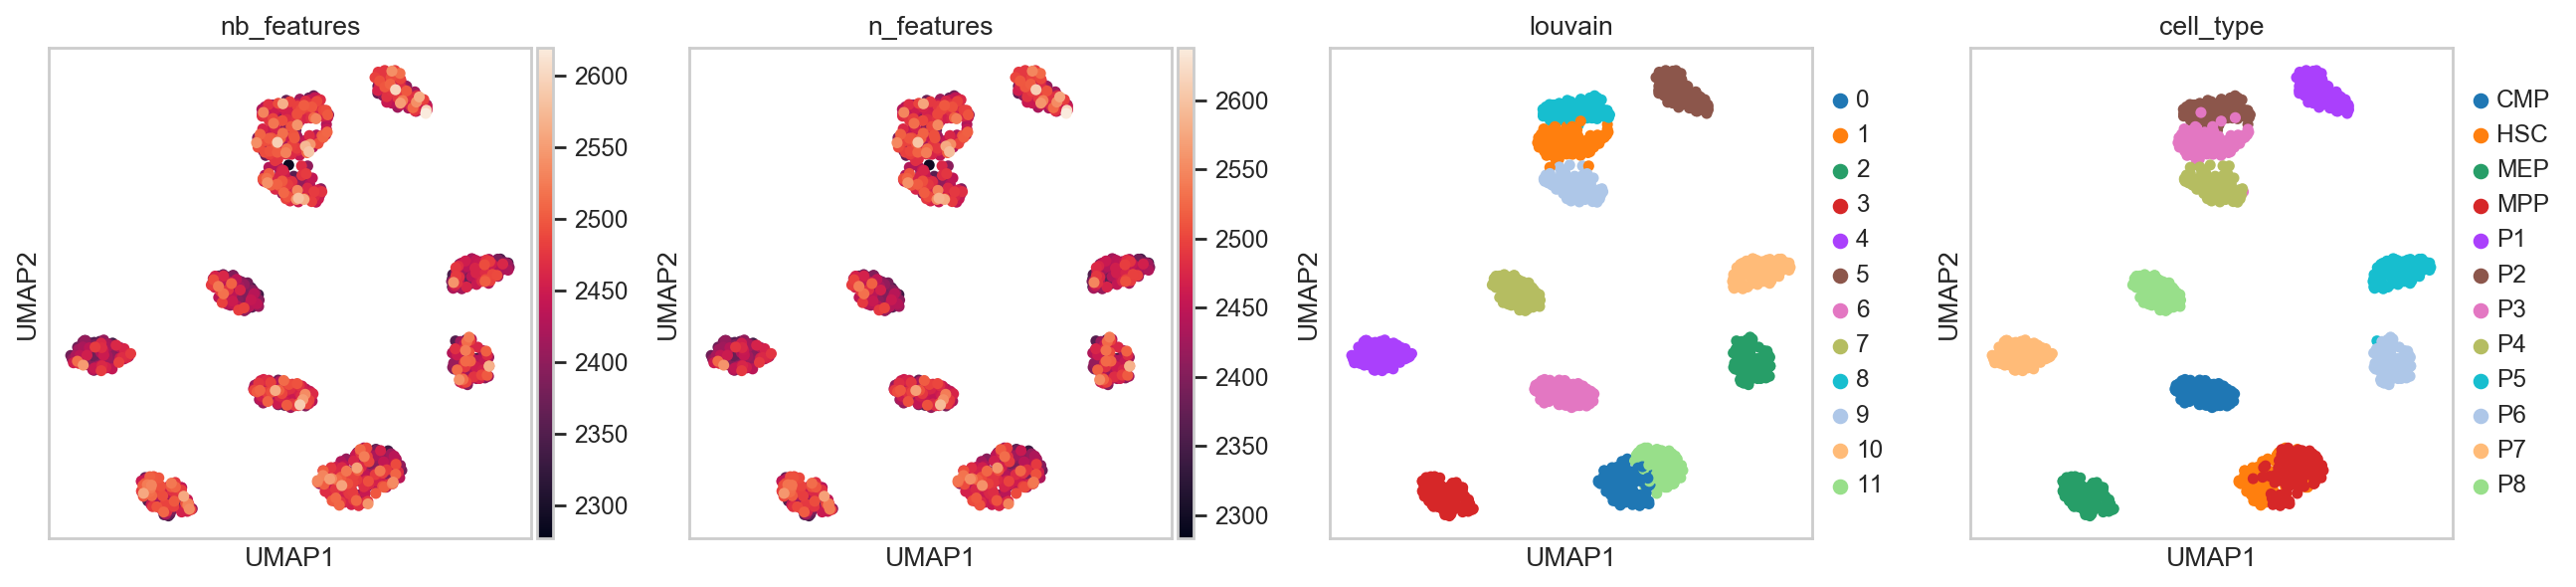

0.9115675862259224 0.9008209627094387 0.8694330769359677


In [23]:
adatareduced = adata.copy()
# convert the cell label to standard label
adatareduced.obs['label'] = adatareduced.obs['cell_type']


epi.pp.pca(adatareduced, n_comps=5)
sc.pp.neighbors(adatareduced, n_neighbors=15)
epi.tl.umap(adatareduced)
#epi.tl.louvain(adatareduced)
getNClusters(adatareduced,n_cluster=num_clusters)
#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['kmeans'] = pd.Series(kmeans.labels_,index=adatareduced.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['hc'] = pd.Series(hc.labels_,index=adatareduced.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
ari_kmeans = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
ari_hc = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['hc'])

sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])
sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

print(ari_louvain, ari_kmeans, ari_hc)

In [28]:
all_metrics ="""Control	0.750941	0.699898	0.696635	0.854198	0.820996	0.823917	0.855354	0.824273	0.822788
BROCKMAN	0.853937	0.710585	0.715	0.912684	0.841918	0.856994	0.911527	0.837232	0.847617
Cusanovich2018	0.833878	0.705488	0.728346	0.91051	0.857965	0.882825	0.912229	0.836235	0.838571
cisTopic	0.859505	0.870247	0.862204	0.925826	0.924597	0.91813	0.924268	0.926108	0.91906
chromVAR_kmers	0.631362	0.683125	0.633939	0.779703	0.811993	0.771349	0.774795	0.809344	0.77325
chromVAR_motifs	0.41833	0.37396	0.349499	0.61227	0.586485	0.558589	0.61134	0.591831	0.559489
chromVAR_kmers_pca	0.694709	0.702174	0.670427	0.844425	0.818812	0.794689	0.790521	0.822046	0.789706
chromVAR_motifs_pca	0.396611	0.351722	0.366967	0.587496	0.583859	0.564477	0.590708	0.588734	0.562235
GeneScoring	0.0127545	0.281442	0.280855	0.0212587	0.501921	0.468168	0.0415435	0.432987	0.44614
GeneScoring_pca	0.295875	0.316226	0.278184	0.504467	0.560827	0.516213	0.508565	0.551597	0.50641
Cicero	0.00345831	0.278615	0.421731	0.00964498	0.498187	0.617713	0.03029	0.411871	0.570884
Cicero_pca	0.357091	0.338578	0.373742	0.544237	0.542257	0.564644	0.535721	0.542227	0.549007
SnapATAC	0.918173	0.92643	0.937413	0.952017	0.952101	0.958222	0.952462	0.953057	0.95892
Scasat	0.762754	0.732875	0.736203	0.864581	0.839181	0.843802	0.857477	0.834717	0.836037
scABC	0.520153	0.39602	0.591362	0.704576	0.647946	0.75744	0.656948	0.564696	0.744747
SCRAT	0.643702	0.604504	0.619747	0.793135	0.783077	0.797117	0.792125	0.780015	0.787514
SCRAT_pca	0.640408	0.594598	0.577834	0.790124	0.774677	0.773088	0.789533	0.773574	0.768022
"""

0.9295849302917766


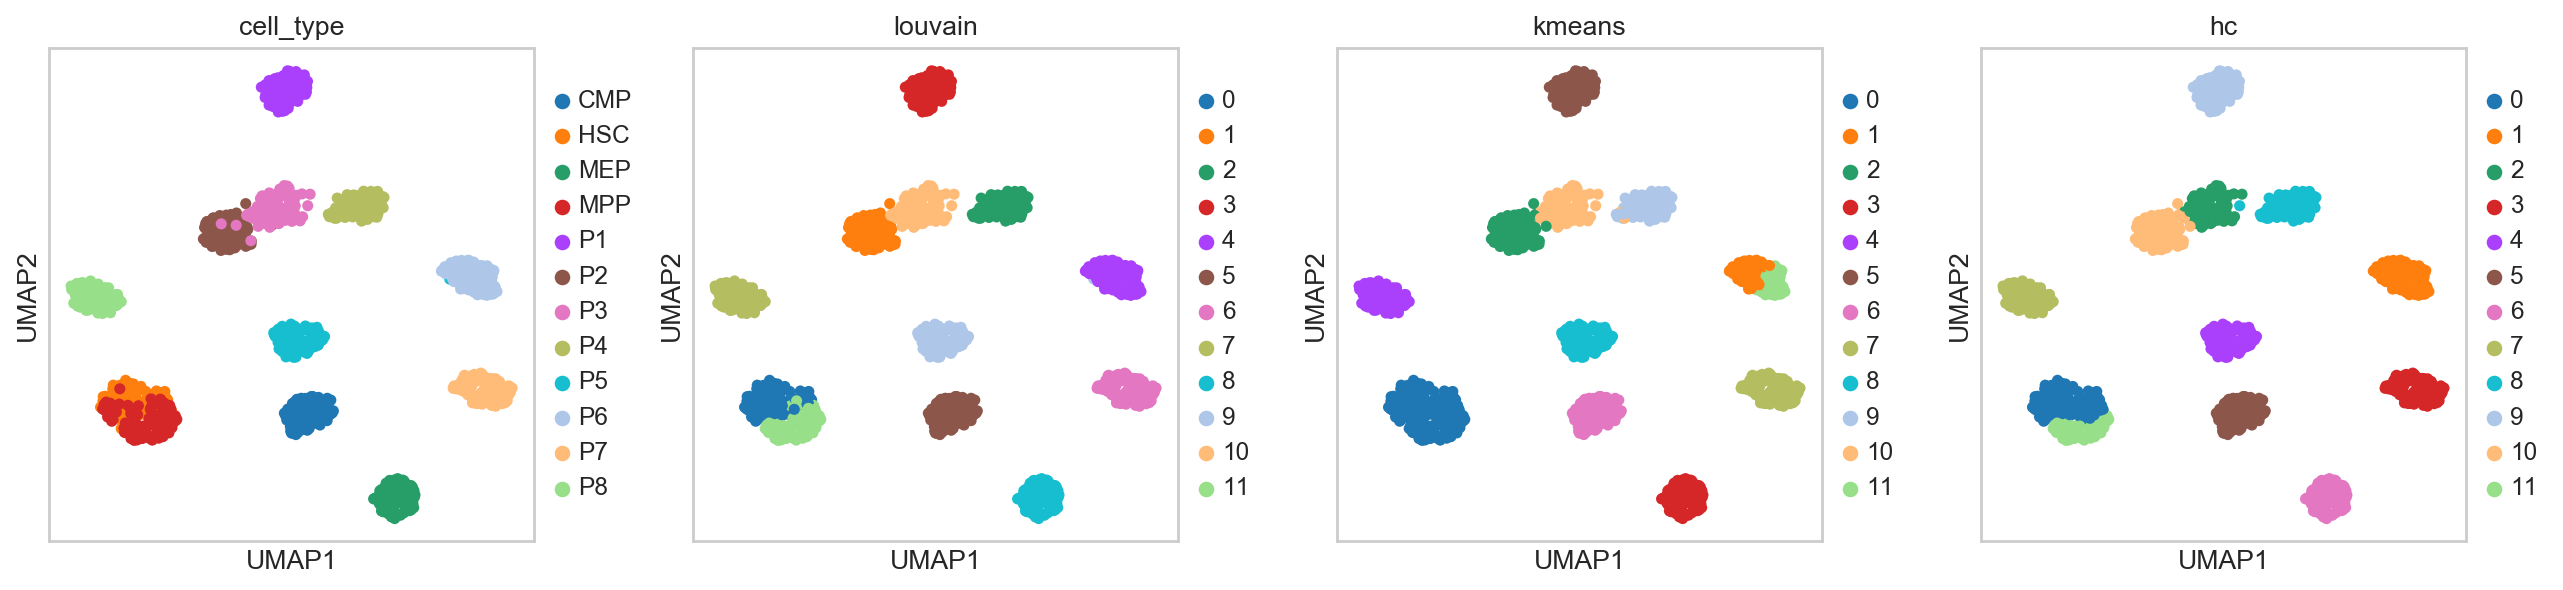

['BROCKMAN', '0.853937', '0.710585', '0.715', '0.912684', '0.841918', '0.856994', '0.911527', '0.837232', '0.847617']
['Cusanovich2018', '0.833878', '0.705488', '0.728346', '0.91051', '0.857965', '0.882825', '0.912229', '0.836235', '0.838571']
['cisTopic', '0.859505', '0.870247', '0.862204', '0.925826', '0.924597', '0.91813', '0.924268', '0.926108', '0.91906']
['chromVAR_kmers', '0.631362', '0.683125', '0.633939', '0.779703', '0.811993', '0.771349', '0.774795', '0.809344', '0.77325']
['chromVAR_motifs', '0.41833', '0.37396', '0.349499', '0.61227', '0.586485', '0.558589', '0.61134', '0.591831', '0.559489']
['chromVAR_kmers_pca', '0.694709', '0.702174', '0.670427', '0.844425', '0.818812', '0.794689', '0.790521', '0.822046', '0.789706']
['chromVAR_motifs_pca', '0.396611', '0.351722', '0.366967', '0.587496', '0.583859', '0.564477', '0.590708', '0.588734', '0.562235']
['GeneScoring', '0.0127545', '0.281442', '0.280855', '0.0212587', '0.501921', '0.468168', '0.0415435', '0.432987', '0.44614'

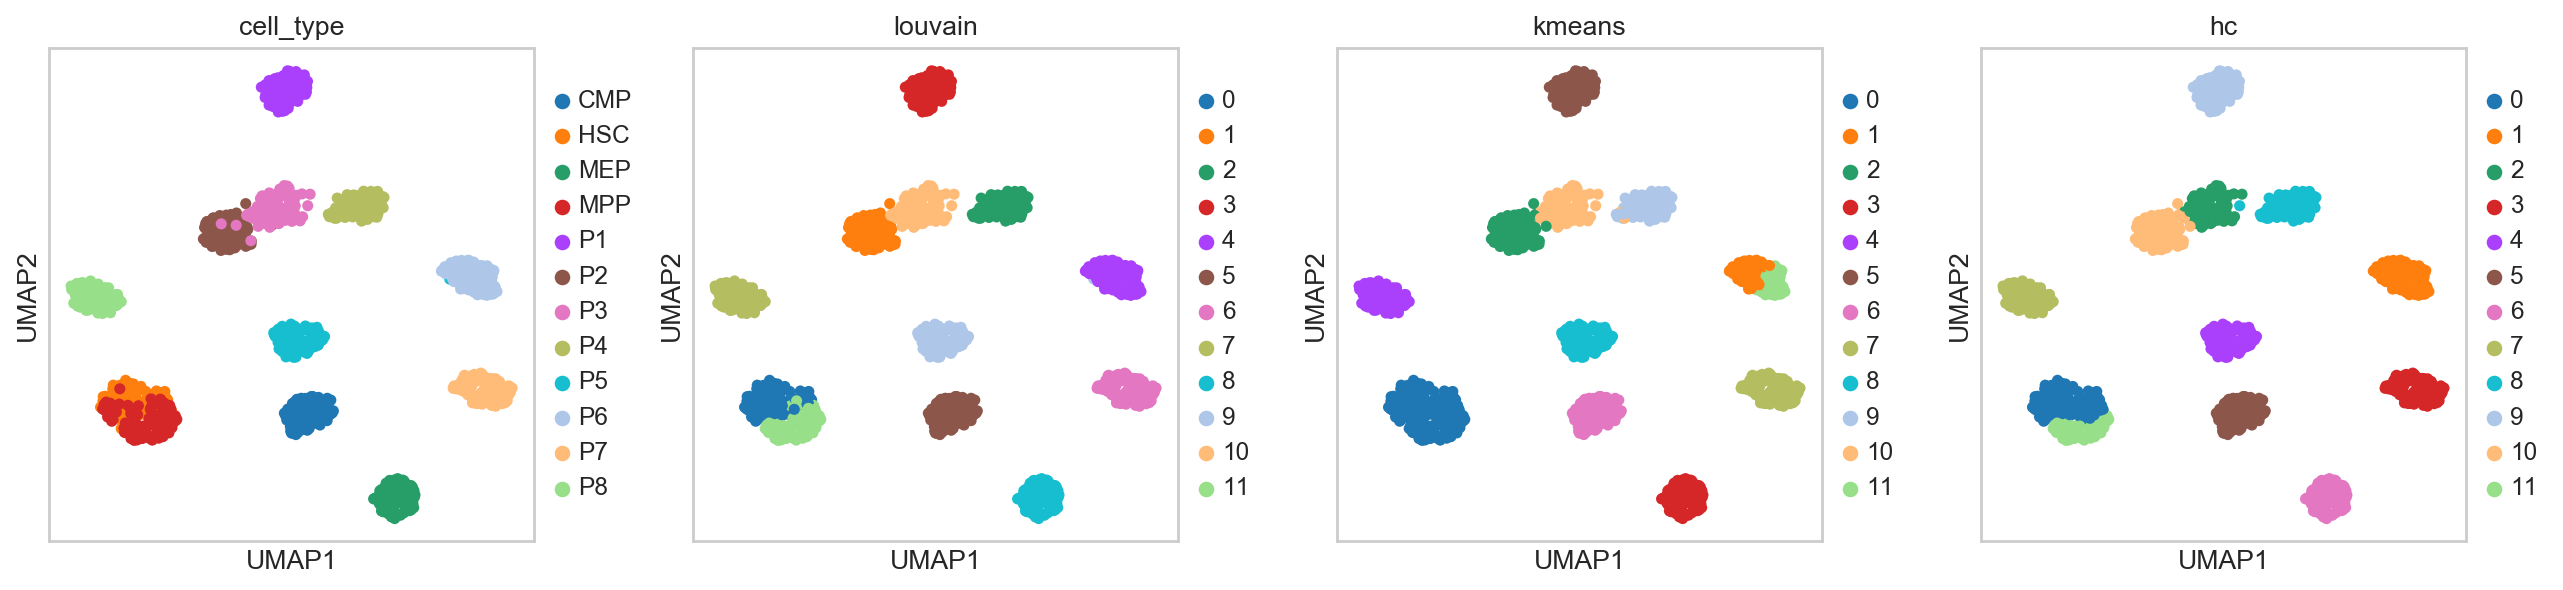

ARI_Louvain  ARI_kmeans    ARI_HC  AMI_Louvain  \
epiScanpy-adata         0.929585    0.872564  0.907386     0.956169   
BROCKMAN                0.853937    0.710585  0.715000     0.912684   
Cusanovich2018          0.833878    0.705488  0.728346     0.910510   
cisTopic                0.859505    0.870247  0.862204     0.925826   
chromVAR_kmers          0.631362    0.683125  0.633939     0.779703   
chromVAR_motifs         0.418330    0.373960  0.349499     0.612270   
chromVAR_kmers_pca      0.694709    0.702174  0.670427     0.844425   
chromVAR_motifs_pca     0.396611    0.351722  0.366967     0.587496   
GeneScoring             0.012755    0.281442  0.280855     0.021259   
GeneScoring_pca         0.295875    0.316226  0.278184     0.504467   
Cicero                  0.003458    0.278615  0.421731     0.009645   
Cicero_pca              0.357091    0.338578  0.373742     0.544237   
SnapATAC                0.918173    0.926430  0.937413     0.952017   
Scasat                  0.762754    0.732875  0.736203     0.864581   
scABC                   0.520153    0.396020  0.591362     0.704576   
SCRAT                   0.643702    0.604504  0.619747     0.793135   
SCRAT_pca               0.640408    0.594598  0.577834     0.790124   

                     AMI_kmeans    AMI_HC  Homogeneity_Louvain  \
epiScanpy-adata        0.945751  0.945852             0.956715   
BROCKMAN               0.841918  0.856994             0.911527   
Cusanovich2018         0.857965  0.882825             0.912229   
cisTopic               0.924597  0.918130             0.924268   
chromVAR_kmers         0.811993  0.771349             0.774795   
chromVAR_motifs        0.586485  0.558589             0.611340   
chromVAR_kmers_pca     0.818812  0.794689             0.790521   
chromVAR_motifs_pca    0.583859  0.564477             0.590708   
GeneScoring            0.501921  0.468168             0.041543   
GeneScoring_pca        0.560827  0.516213             0.508565   
Cicero                 0.498187  0.617713             0.030290   
Cicero_pca             0.542257  0.564644             0.535721   
SnapATAC               0.952101  0.958222             0.952462   
Scasat                 0.839181  0.843802             0.857477   
scABC                  0.647946  0.757440             0.656948   
SCRAT                  0.783077  0.797117             0.792125   
SCRAT_pca              0.774677  0.773088             0.789533   

                     Homogeneity_kmeans  Homogeneity_HC               method  
epiScanpy-adata                0.935876        0.944997      epiScanpy-adata  
BROCKMAN                       0.837232        0.847617             BROCKMAN  
Cusanovich2018                 0.836235        0.838571       Cusanovich2018  
cisTopic                       0.926108        0.919060             cisTopic  
chromVAR_kmers                 0.809344        0.773250       chromVAR_kmers  
chromVAR_motifs                0.591831        0.559489      chromVAR_motifs  
chromVAR_kmers_pca             0.822046        0.789706   chromVAR_kmers_pca  
chromVAR_motifs_pca            0.588734        0.562235  chromVAR_motifs_pca  
GeneScoring                    0.432987        0.446140          GeneScoring  
GeneScoring_pca                0.551597        0.506410      GeneScoring_pca  
Cicero                         0.411871        0.570884               Cicero  
Cicero_pca                     0.542227        0.549007           Cicero_pca  
SnapATAC                       0.953057        0.958920             SnapATAC  
Scasat                         0.834717        0.836037               Scasat  
scABC                          0.564696        0.744747                scABC  
SCRAT                          0.780015        0.787514                SCRAT  
SCRAT_pca                      0.773574        0.768022            SCRAT_pca

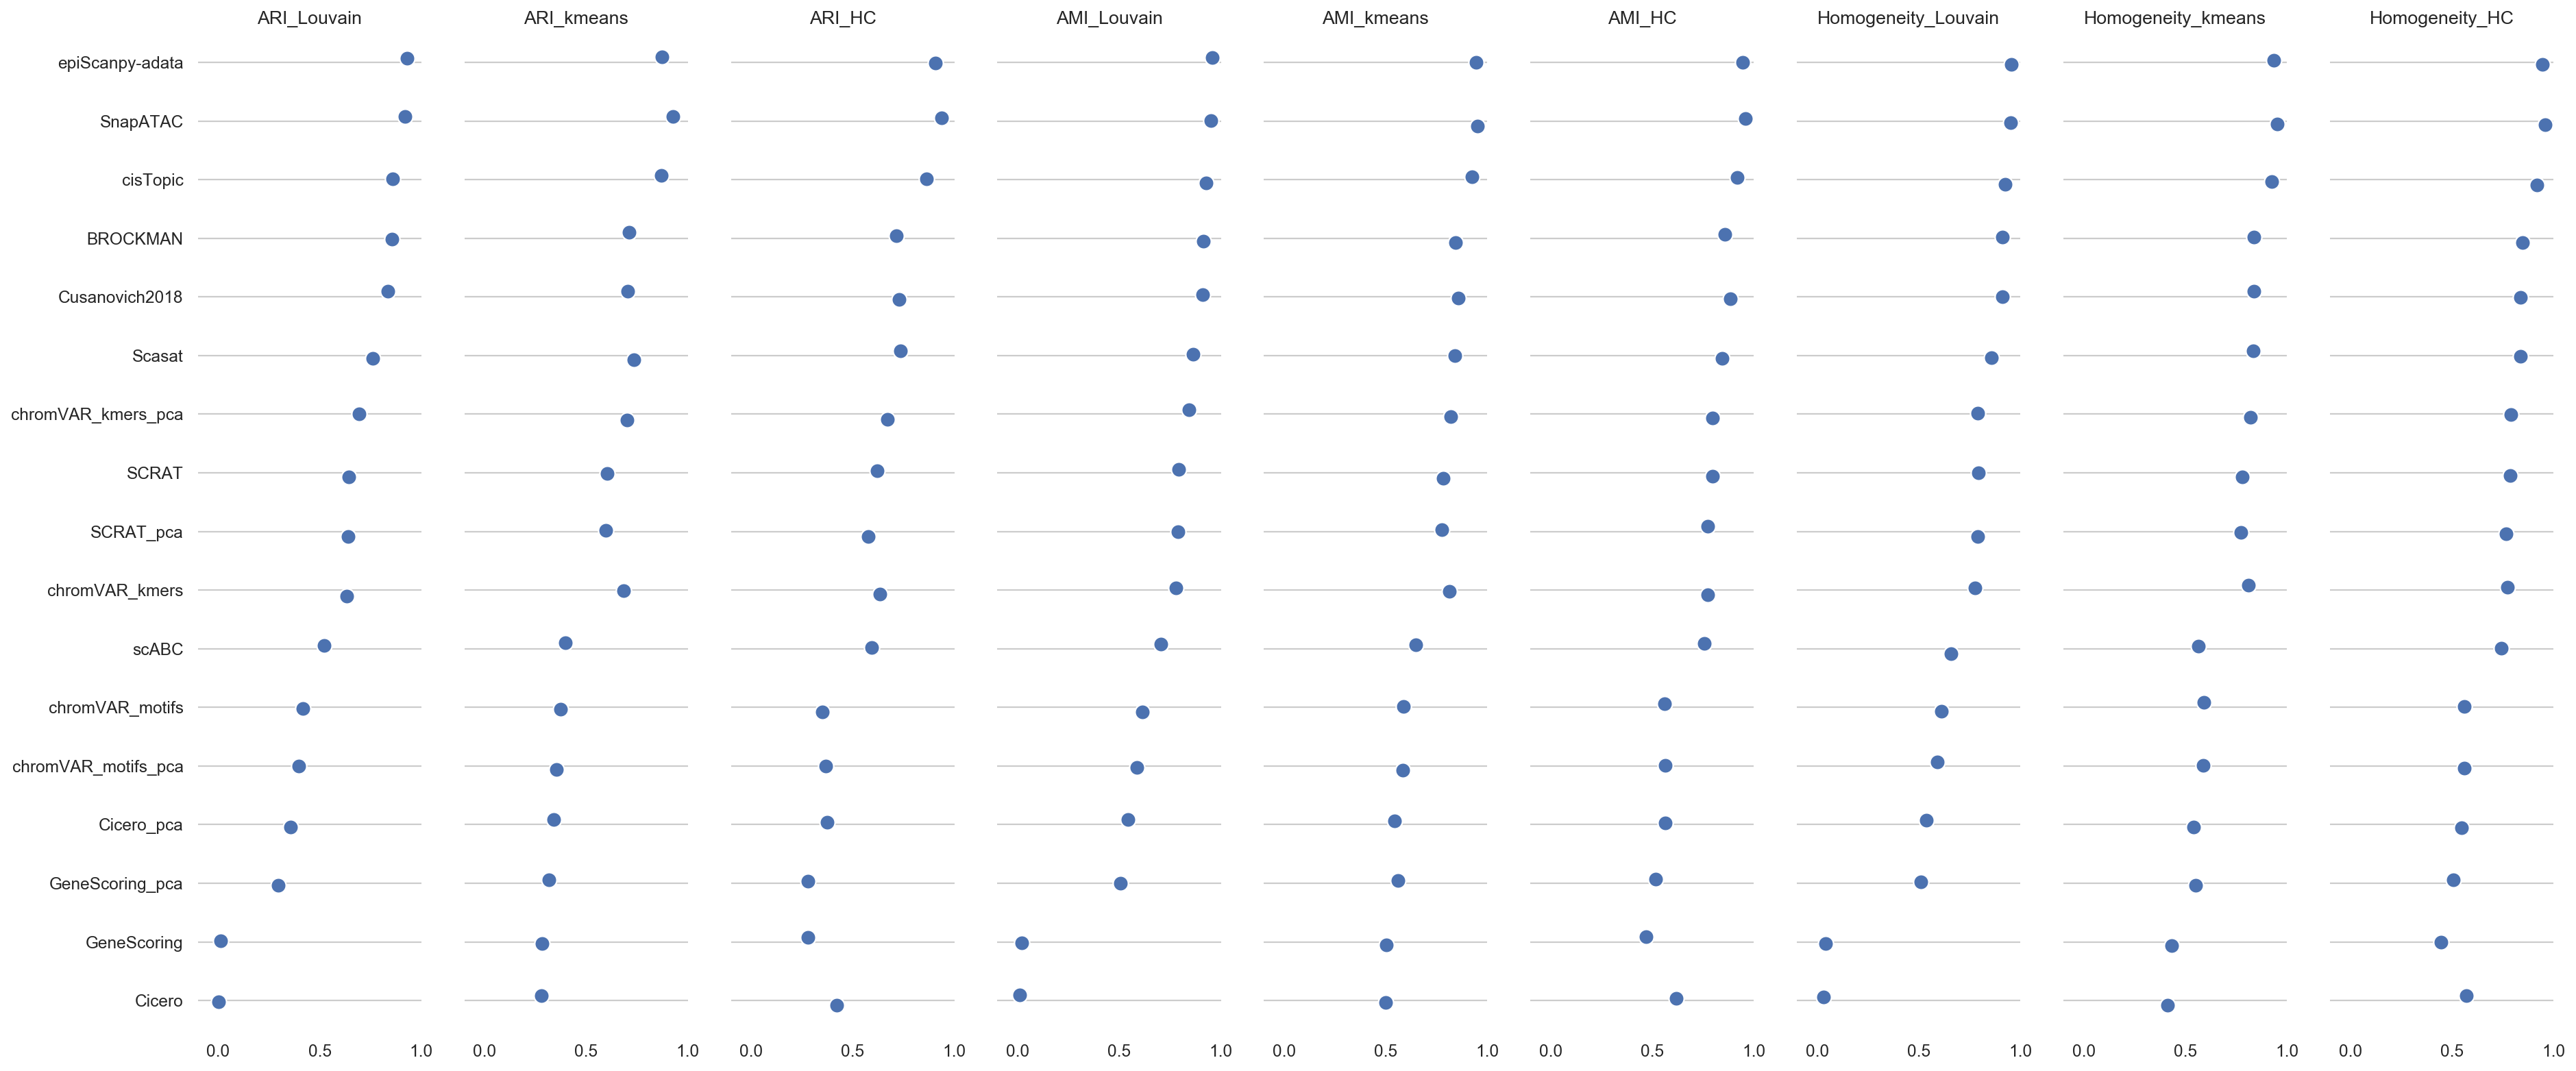

In [29]:
adata = adatareduced.copy()

from sklearn.metrics import adjusted_rand_score

labels_true = adata.obs['cell_type']
labels_pred = adata.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))
    
df_metrics = pd.DataFrame(columns=['ARI_Louvain','ARI_kmeans','ARI_HC',
                                   'AMI_Louvain','AMI_kmeans','AMI_HC',
                                   'Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC'])


# set method name
method = 'epiScanpy-adata'

# convert the cell label to standard label
adata.obs['label'] = adata.obs['cell_type']

# set the number of cluster for louvain
num_clusters = len(np.unique(adata.obs['label']))
#print(num_clusters)

# set the epiScanpy metric raw in the pandas dataframe
df_metrics.loc[method,] = ""

## get the clusters

#Louvain
#sc.pp.neighbors(adata, n_neighbors=15,use_rep='X') # I MUST NOT recalculate the neighboring graph like this
#sc.tl.louvain(adata)
getNClusters(adata,n_cluster=num_clusters)

#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = pd.Series(kmeans.labels_,index=adata.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.obsm['X_pca'])
adata.obs['hc'] = pd.Series(hc.labels_,index=adata.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adata.obs['label'], adata.obs['louvain'])
ari_kmeans = adjusted_rand_score(adata.obs['label'], adata.obs['kmeans'])
ari_hc = adjusted_rand_score(adata.obs['label'], adata.obs['hc'])
#adjusted mutual information
ami_louvain = adjusted_mutual_info_score(adata.obs['label'], adata.obs['louvain'],average_method='arithmetic')
ami_kmeans = adjusted_mutual_info_score(adata.obs['label'], adata.obs['kmeans'],average_method='arithmetic')   
ami_hc = adjusted_mutual_info_score(adata.obs['label'], adata.obs['hc'],average_method='arithmetic')
#homogeneity
homo_louvain = homogeneity_score(adata.obs['label'], adata.obs['louvain'])
homo_kmeans = homogeneity_score(adata.obs['label'], adata.obs['kmeans'])
homo_hc = homogeneity_score(adata.obs['label'], adata.obs['hc'])

df_metrics.loc[method,['ARI_Louvain','ARI_kmeans','ARI_HC']] = [ari_louvain,ari_kmeans,ari_hc]
df_metrics.loc[method,['AMI_Louvain','AMI_kmeans','AMI_HC']] = [ami_louvain,ami_kmeans,ami_hc]
df_metrics.loc[method,['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = [homo_louvain,homo_kmeans,homo_hc] 
#adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]

for line in all_metrics[1:]:
    print(line)
    df_metrics.loc[line[0],['ARI_Louvain','ARI_kmeans','ARI_HC']] = line[1:4]
    df_metrics.loc[line[0],['AMI_Louvain','AMI_kmeans','AMI_HC']] = line[4:7]
    df_metrics.loc[line[0],['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = line[7:]

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


for key in df_metrics.keys():
    df_metrics[key] = [float(key) for key in df_metrics[key]]
    
df_metrics['method'] = df_metrics.index.tolist()


sns.set(style="whitegrid")

# data to plot
df_metrics

# Make the PairGrid
g = sns.PairGrid(df_metrics.sort_values("ARI_Louvain",
                                        ascending=False),
                 x_vars=df_metrics.columns[:9], y_vars=["method"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      #palette="ch:s=1,r=-.1,h=1_r",
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.), xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['ARI_Louvain', 'ARI_kmeans', 'ARI_HC',
          'AMI_Louvain', 'AMI_kmeans', 'AMI_HC',
          'Homogeneity_Louvain', 'Homogeneity_kmeans', 'Homogeneity_HC']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

df_metrics

In [ ]:
#sc.pp.normalize_total(adatavar, target_sum=1e6, exclude_highly_expressed=False,
#                                      max_fraction=0.05, key_added=None, layers=None,
#                                      layer_norm=None, inplace=True)

#sc.pp.log1p(adatavar)
#sc.pp.highly_variable_genes(adatavar, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adatavar)
#adatavar = adatavar[:, adatavar.var['highly_variable']]
#print(adatavar)

for n in range(5,50,5):
    sc.pp.neighbors(adata, n_neighbors=n)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['cell_type', 'n_features'])

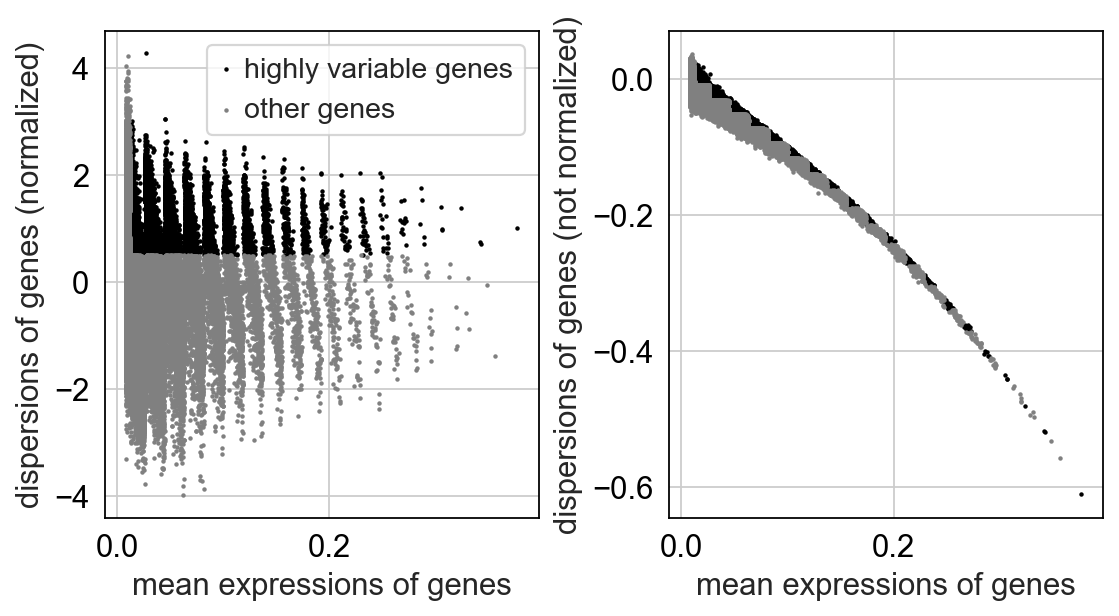

View of AnnData object with n_obs × n_vars = 1200 × 12140 
    obs: 'cell_type', 'n_features'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


... storing 'cell_type' as categorical


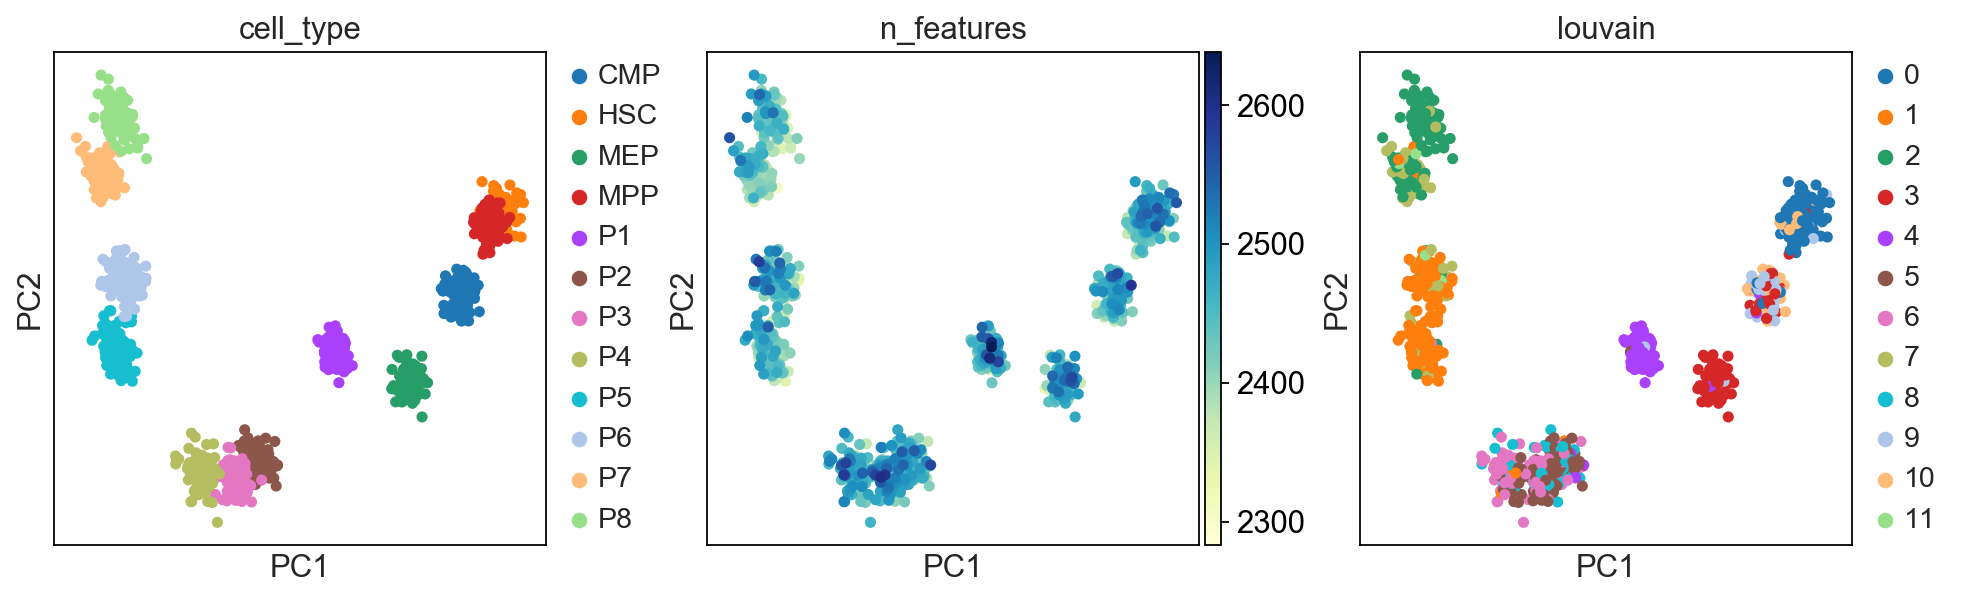

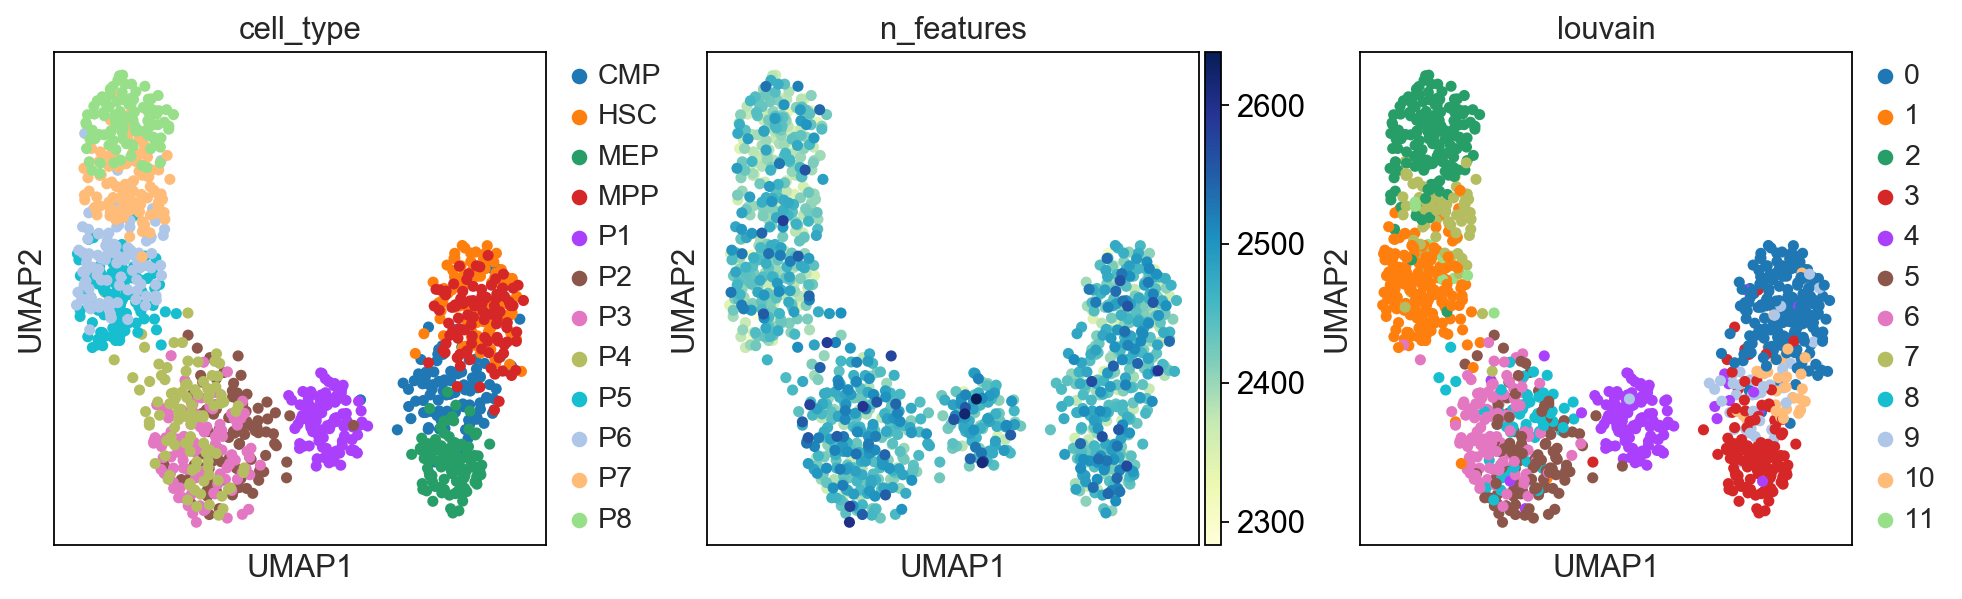

0.4913093645012658


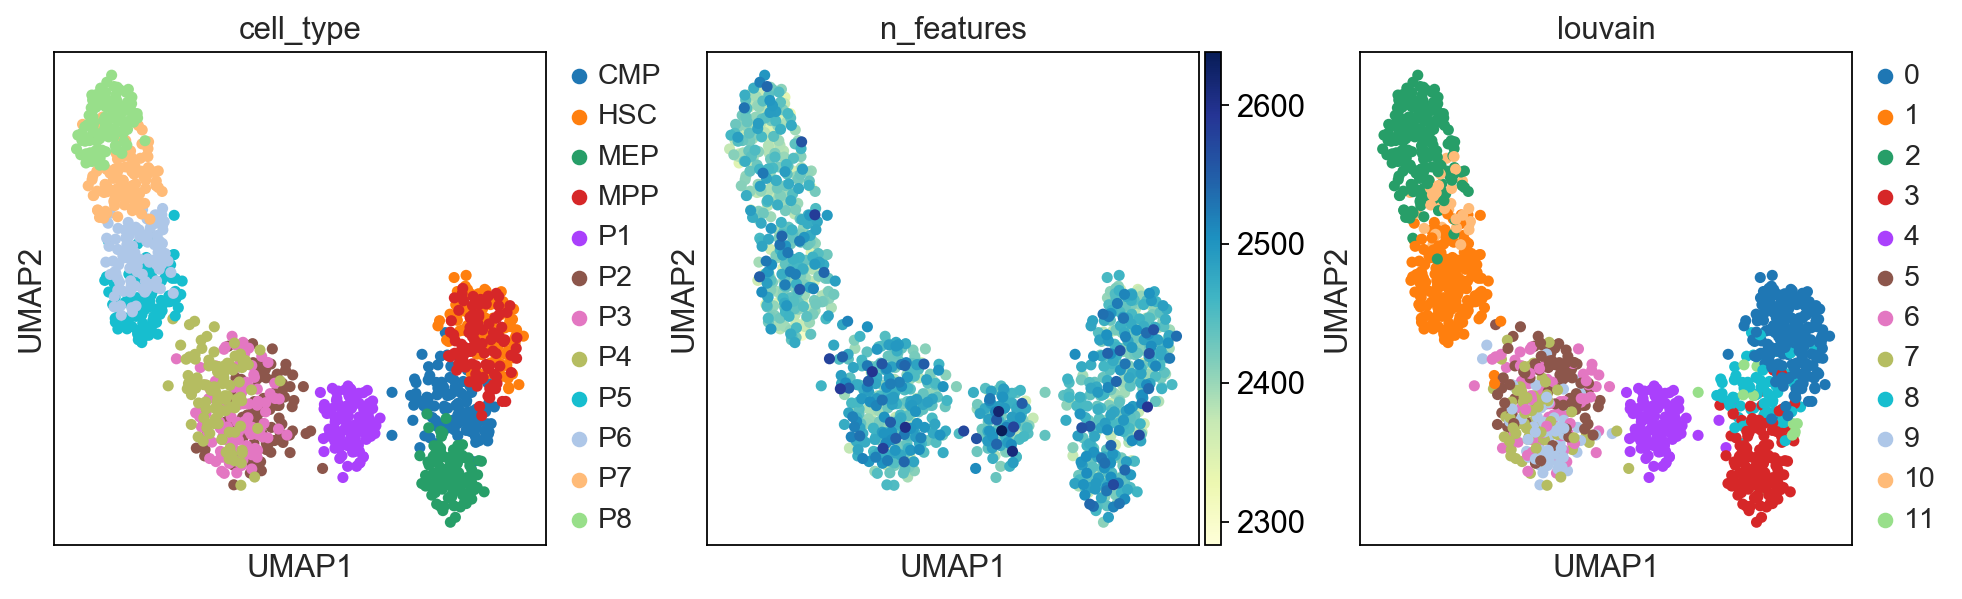

10 0.5470179623958558


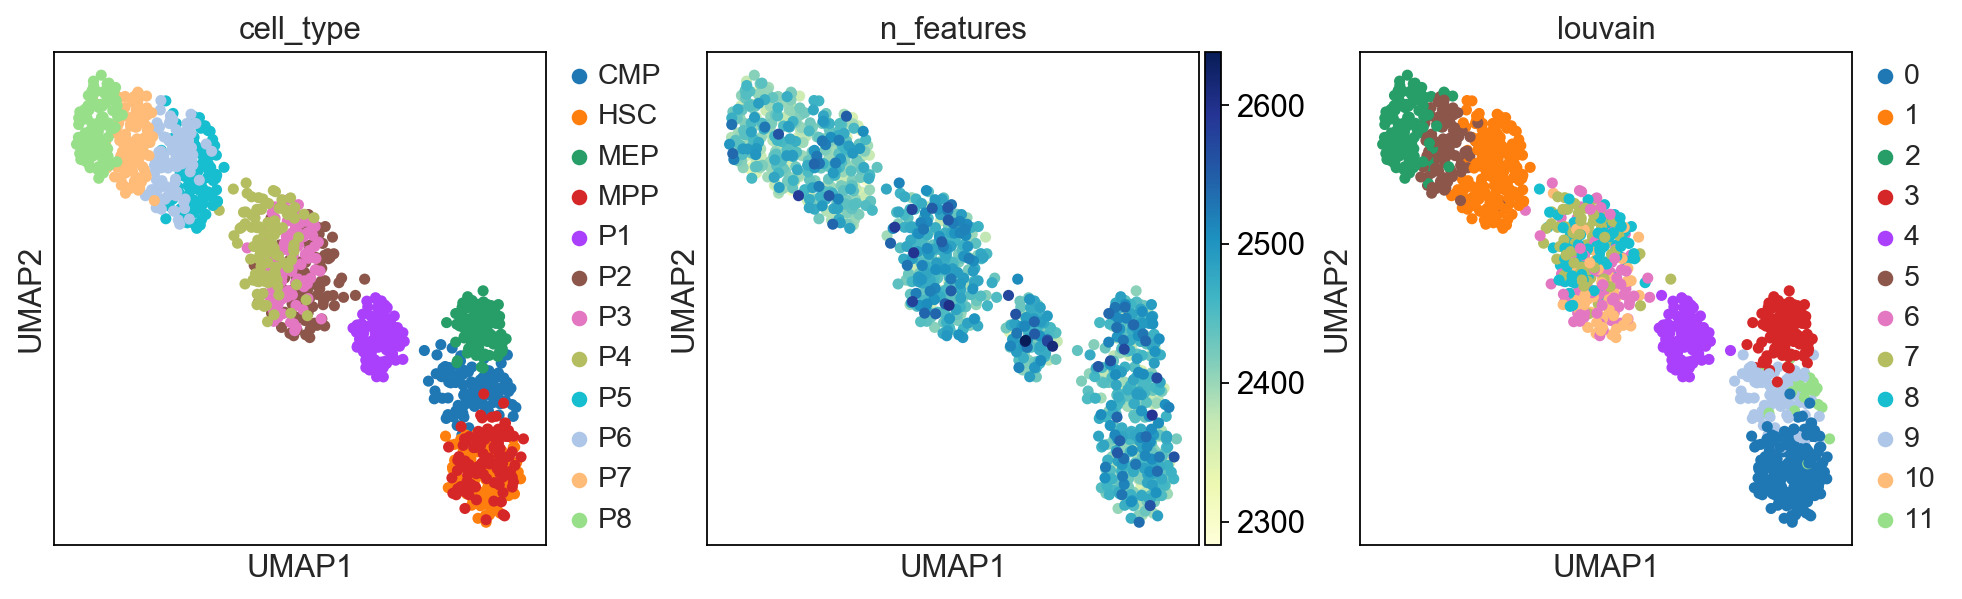

15 0.6053772302587649


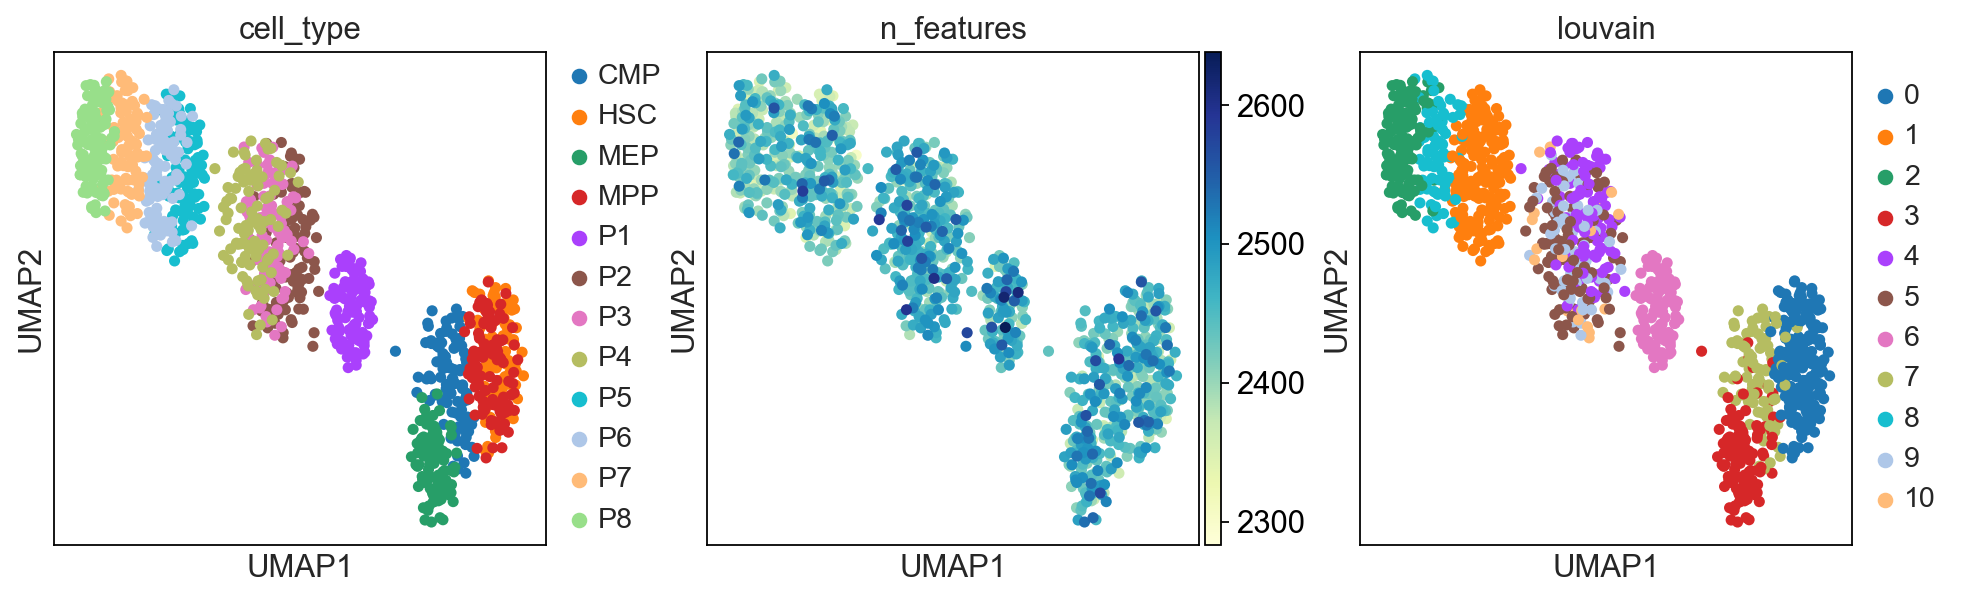

20 0.6064689514248417


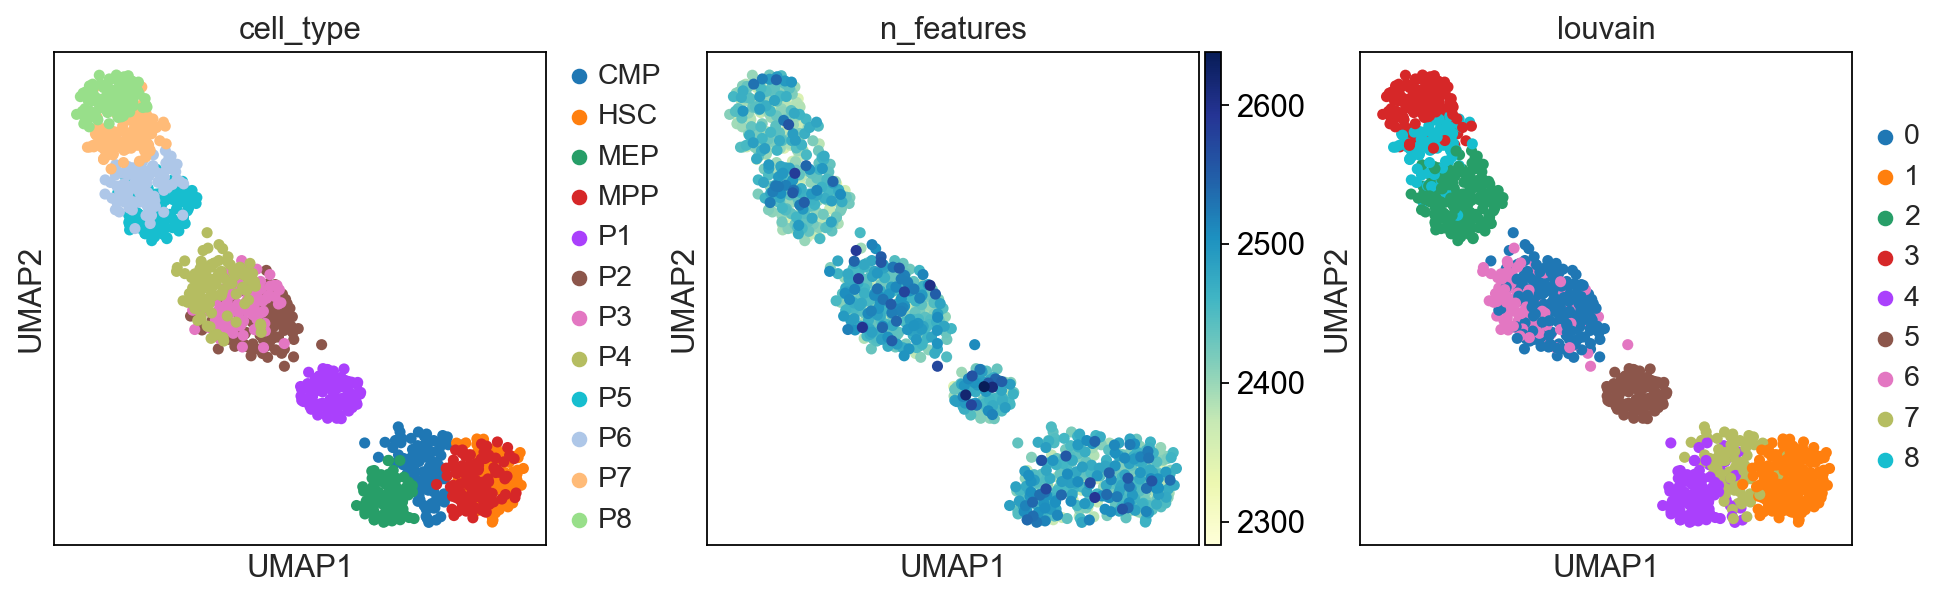

25 0.6071822496255062


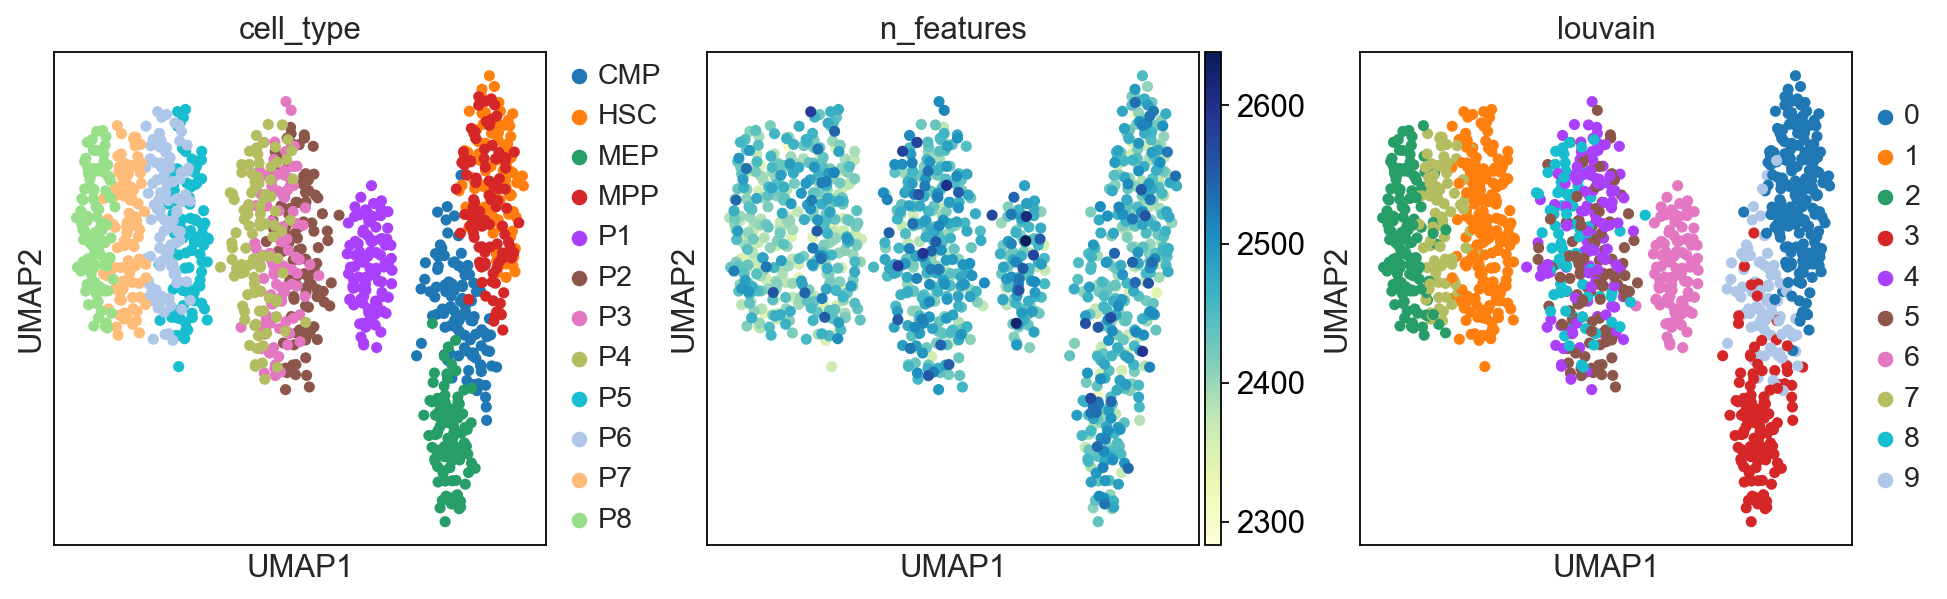

30 0.6025813538216767


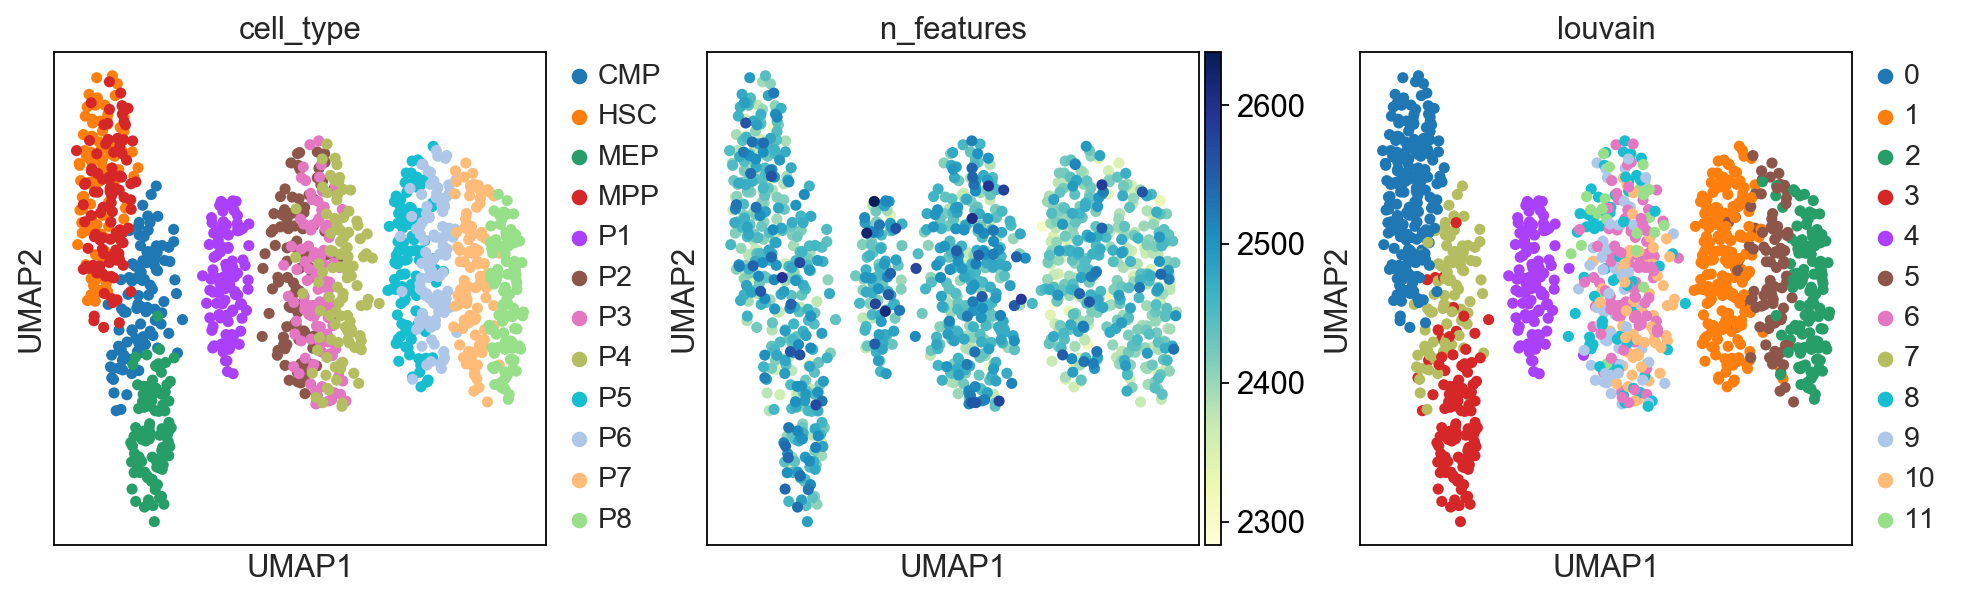

35 0.6175723192860509


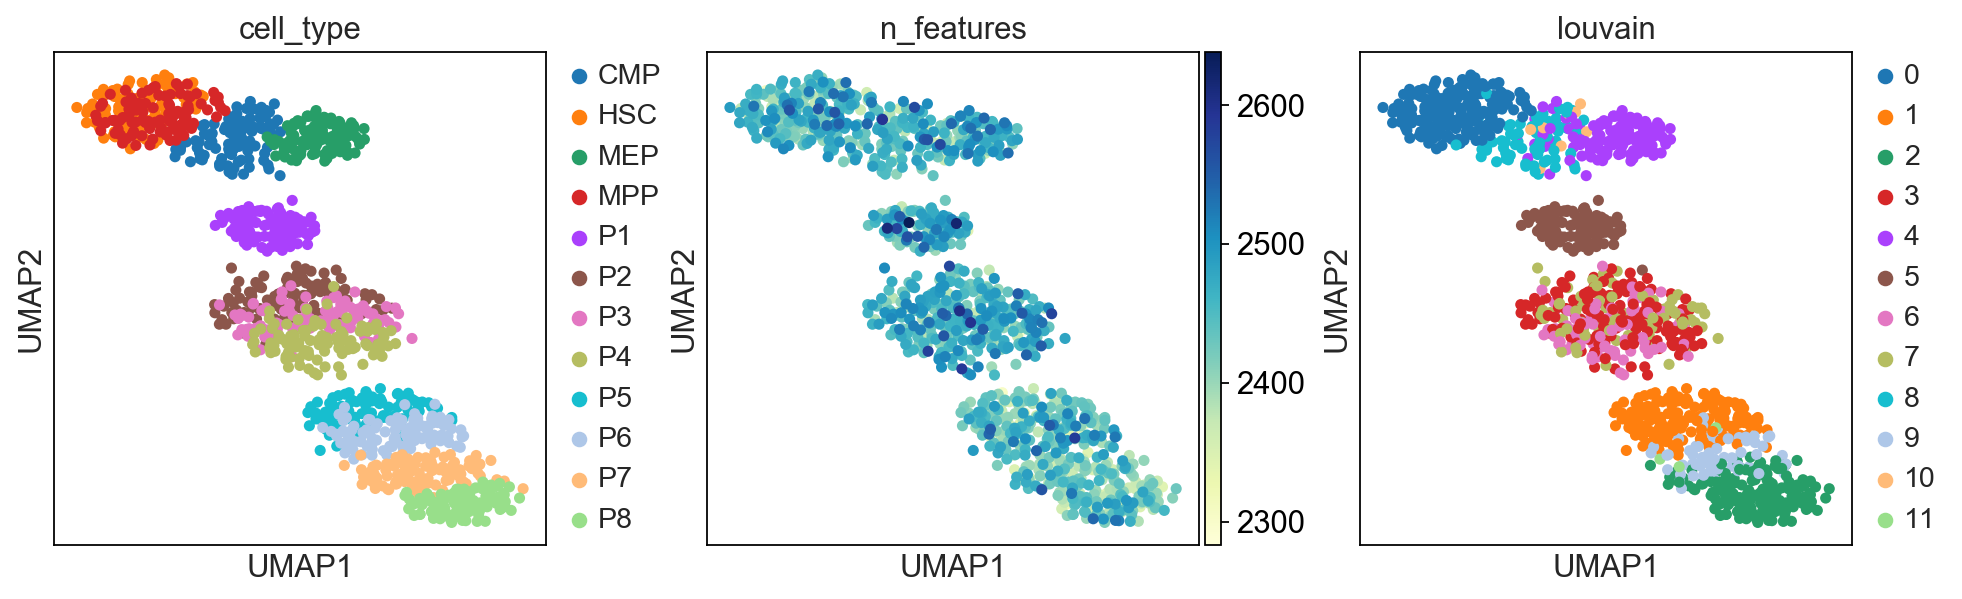

40 0.5795218561927257


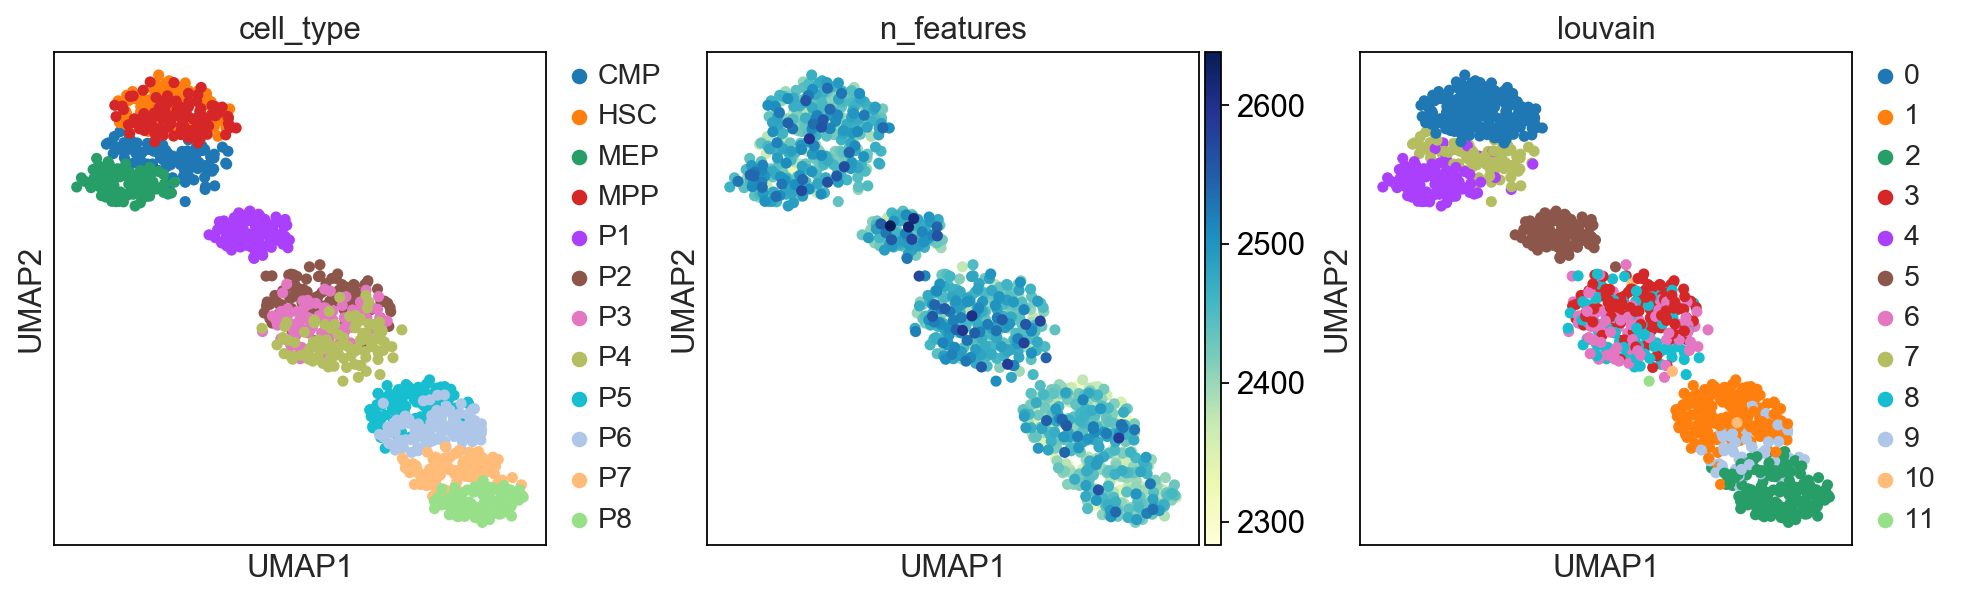

45 0.600321765343876


In [27]:
def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        #print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        #print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    #print('Cannot find the number of clusters')
    #print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))
    

adata = ad.AnnData(mtx,
                   obs=pd.DataFrame(index=cells),
                   var=pd.DataFrame(index=features))

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')


# load metadata
metadata = pd.read_csv('./input/metadata.tsv',sep='\t',index_col=0)
num_clusters = len(np.unique(metadata['label']))
adata.obs['cell_type'] = metadata['label']

epi.pp.binarize(adata)

epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=10)

sc.pp.pca(adata, n_comps=100)
#sc.pl.pca(adata, color=['cell_type', 'n_features'])
sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=False,
                                      max_fraction=0.05, key_added=None, layers=None,
                                      layer_norm=None, inplace=True)

sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]
print(adata)

sc.pp.neighbors(adata, n_neighbors=5)
sc.tl.umap(adata)
getNClusters(adata,n_cluster=num_clusters)
sc.pl.pca(adata, color=['cell_type', 'n_features', 'louvain'])
sc.pl.umap(adata, color=['cell_type', 'n_features', 'louvain'])

labels_true = adata.obs['cell_type']
labels_pred = adata.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

for n in range(10,50,5):
    
    sc.pp.neighbors(adata, n_neighbors=n)
    sc.tl.umap(adata)
    getNClusters(adata,n_cluster=num_clusters)
    sc.pl.umap(adata, color=['cell_type', 'n_features', 'louvain'])

    labels_true = adata.obs['cell_type']
    labels_pred = adata.obs['louvain']
    print(n, adjusted_rand_score(labels_true, labels_pred))

... storing 'cell_type' as categorical


AnnData object with n_obs × n_vars = 1200 × 93371 
    obs: 'cell_type', 'n_features'
    var: 'n_cells'


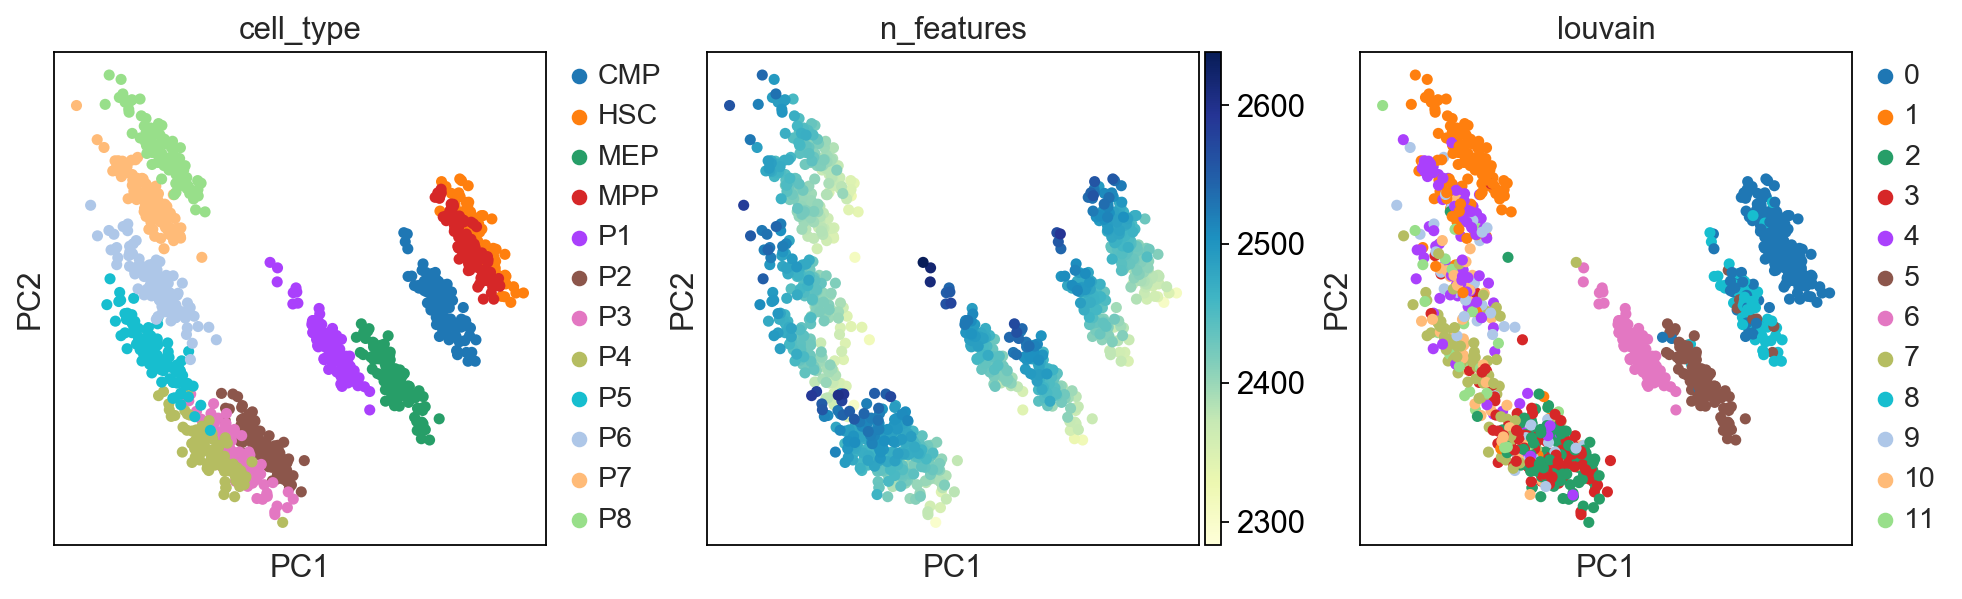

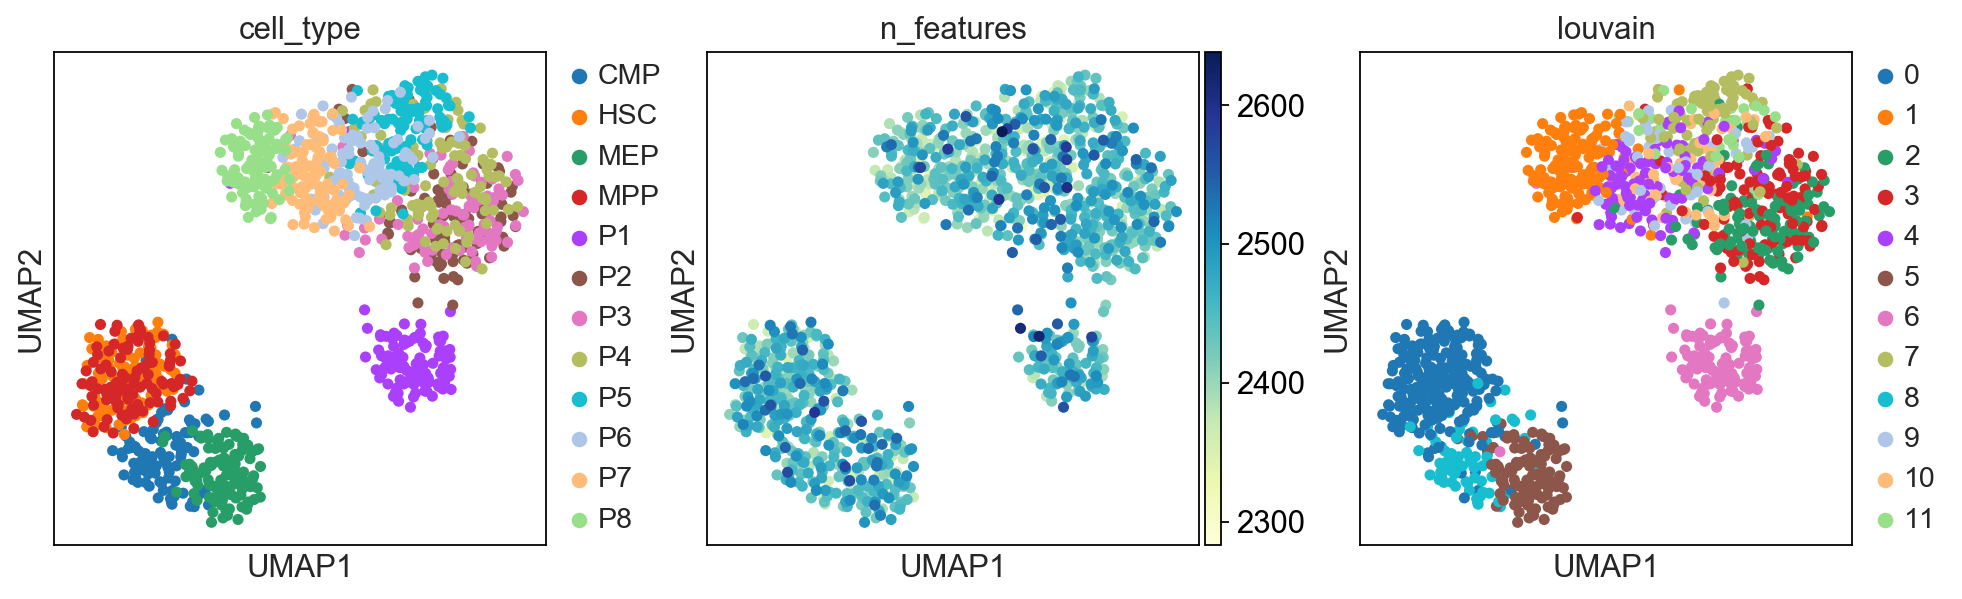

0.4635371293179695


TypeError: 'type' object is not subscriptable

In [37]:
adata = ad.AnnData(mtx,
                   obs=pd.DataFrame(index=cells),
                   var=pd.DataFrame(index=features))

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')


# load metadata
metadata = pd.read_csv('./input/metadata.tsv',sep='\t',index_col=0)
num_clusters = len(np.unique(metadata['label']))
adata.obs['cell_type'] = metadata['label']

epi.pp.binarize(adata)

epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=5)



#sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=False,
#                                      max_fraction=0.05, key_added=None, layers=None,
#                                      layer_norm=None, inplace=True)

#sc.pp.log1p(adata)

#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)
#adata = adata[:, adata.var['highly_variable']]

sc.pp.regress_out(adata, 'n_features')

print(adata)

sc.pp.pca(adata, n_comps=100, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=5)
sc.tl.umap(adata)
getNClusters(adata,n_cluster=num_clusters)
sc.pl.pca(adata, color=['cell_type', 'n_features', 'louvain'])
sc.pl.umap(adata, color=['cell_type', 'n_features', 'louvain'])

labels_true = adata.obs['cell_type']
labels_pred = adata.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

for n in range[25]:
    
    sc.pp.neighbors(adata, n_neighbors=n)
    sc.tl.umap(adata)
    getNClusters(adata,n_cluster=num_clusters)
    sc.pl.umap(adata, color=['cell_type', 'n_features', 'louvain'])

    labels_true = adata.obs['cell_type']
    labels_pred = adata.obs['louvain']
    print(n, adjusted_rand_score(labels_true, labels_pred))

In [ ]:
adata = ad.AnnData(mtx,
                   obs=pd.DataFrame(index=cells),
                   var=pd.DataFrame(index=features))

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')


# load metadata
metadata = pd.read_csv('./input/metadata.tsv',sep='\t',index_col=0)
num_clusters = len(np.unique(metadata['label']))
adata.obs['cell_type'] = metadata['label']

epi.pp.binarize(adata)

epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=10)


#sc.pl.pca(adata, color=['cell_type', 'n_features'])
sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=False,
                                      max_fraction=0.05, key_added=None, layers=None,
                                      layer_norm=None, inplace=True)

sc.pp.log1p(adata)

#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)
#adata = adata[:, adata.var['highly_variable']]
print(adata)

sc.pp.pca(adata, n_comps=100, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=5)
sc.tl.umap(adata)
getNClusters(adata,n_cluster=num_clusters)
sc.pl.pca(adata, color=['cell_type', 'n_features', 'louvain'])
sc.pl.umap(adata, color=['cell_type', 'n_features', 'louvain'])

labels_true = adata.obs['cell_type']
labels_pred = adata.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

for n in range(10,50,5):
    
    sc.pp.neighbors(adata, n_neighbors=n)
    sc.tl.umap(adata)
    getNClusters(adata,n_cluster=num_clusters)
    sc.pl.umap(adata, color=['cell_type', 'n_features', 'louvain'])

    labels_true = adata.obs['cell_type']
    labels_pred = adata.obs['louvain']
    print(n, adjusted_rand_score(labels_true, labels_pred))